# Global variables

In [2]:
# Interval of bins (a,b)
a = 190
b = 220

# Minimum count rate for fits
minCPS = 0.15

# Main code
Functions for data analysis

In [3]:
import h5py
import os
import sys
from glob import glob
from math import factorial, ceil, floor
from numpy import genfromtxt, sum, array,sqrt,zeros,exp,diag, pi,arange, sin, cos,vstack,log, mean, ones
from pylab import show,grid,subplots, suptitle,fill_between, subplots_adjust,axes,figure,tight_layout, axis,xticks,yticks,savefig, errorbar, scatter,legend, colorbar, xlabel, ylabel, title, imshow,plot, subplot, axvspan,xlim,ylim,stem,setp
from matplotlib import gridspec, cm
from scipy.optimize import curve_fit


## SORTING AND ORGANIZATION #############################
#########################################################

# Returns a list with combined data bins
def reduceBins(histograms,comb):
    # -----PARAMETERS-----
    # histograms           | list => [counts (1D array), time, filenames]
    # comb                 | int => Number of bins to combine
    # -----RETURNS-----
    # reducedBinHistograms | list => [counts (1D array), time, filenames]
    
    
    reducedBinHistograms = []
    n = 0
    for i in histograms:
        combBins = []
        for j in range(0,len(i[0]),comb):
            s = 0
            for k in range(comb):
                if (j+k) < len(i[0]):
                    s += i[0][j+k]
            combBins.append(s)
        reducedBinHistograms.append([array(combBins), i[1], i[2]])

    return reducedBinHistograms


# Returns lists of the data split by the total time of integration
def sort_and_split_by_time(histograms,remover=0):
    # -----PARAMETERS-----
    # histograms         | List => histograms[n] = [counts (1D array), time, filenames]
    # remover (optional) | int => 0 - don't remove histograms
    #                    |     => 1 - remove bad histograms
    # -----RETURNS-----
    # splitHistogramList | list of lists => splitHistogramList[n] = [[counts (1D array), time, filenames],
    #                                                                [counts (1D array), time, filenames],
    #                                                                ...]
    
    sortedHistograms = sort_mesurements_by_time(histograms,remover)
    values = 1
    for i in range(len(sortedHistograms)):
        if i != (len(sortedHistograms)-1):
            if sortedHistograms[i][1] != sortedHistograms[i+1][1]:
              values +=1
    splitHistogramList = []
    for i in range(values):
        splitHistogramList.append([])

    n = 0
    for i in range(values):
        splitHistogramList[i].append(sortedHistograms[n])
        n +=1
        for j in range(n,len(sortedHistograms)):
            if sortedHistograms[j][1] == splitHistogramList[i][-1][1]:
                splitHistogramList[i].append(sortedHistograms[j])
                n += 1
            else:
                break
    return splitHistogramList


# Sorts histograms from shortest time to longest
def sort_mesurements_by_time(histograms, remover=0):
    # -----PARAMETERS-----
    # histograms         | List => histograms[n] = [counts (1D array), time, filenames]
    # remover (optional) | int => 0 - don't remove histograms
    #                    |     => 1 - remove bad histograms
    # -----RETURNS-----
    # histogramsByTime   | List => histograms[n] = [counts (1D array), time, filenames]

    histogramsByTime = []
    temp = []
    addedFiles = []

    # Sort data
    for i in histograms:
        temp.append(i[1])
    while len(temp) != 0:
        for j in histograms:
            if j[1] == min(temp) and (j[2] not in addedFiles):
                histogramsByTime.append(j)
                addedFiles.append(j[2])
                temp.remove(min(temp))
                break
    indexList = []
    if remover==1:
        for i in range(len(histogramsByTime)):
            if (sum(histogramsByTime[i][0])/ histogramsByTime[i][1]) < minCPS:
                indexList.append(i)
        m = 0
        for n in indexList:
            histogramsByTime.pop(n-m)
            m += 1
    return histogramsByTime


## EQUATIONS ############################################
#########################################################

# Gaussian curve equation function
def gaussian_curve(x, a1, p1, w1, a2=0, p2=0, w2=0, doubleGauss=0):
    # -----PARAMETERS-----
    # x  | float => bin number
    # a  | float => amplitude
    # p  | float => peak pos (height)
    # w  | float => FWHM

    return a1*exp(-(4*log(2)*(x-p1)**2)/(w1**2))+a2*exp(-(4*log(2)*(x-p2)**2)/(w2**2))   # In terms of FWTM


# Cosine function with amplitude parameter
def cosineFunction(x,a):
    # -----PARAMETERS-----
    # x | angle
    # a | amplitude
    
    return a*cos(x)


# Returns the values corresponding to a Poisson function
def poisson_distribution(ocurrences,rate):
    # -----PARAMETERS-----
    # ocurrences | int => number of counts
    # rate       | float => count rate
    return (rate**ocurrences)/(factorial(ocurrences)*exp(rate))


# Returns the reduced Chi Square for a fit
def chi2_test(observed,expected):
    # -----PARAMETERS-----
    # observed   | array/list => measured values
    # expected   | array/list => fit values

    chi2 = 0
    for i in range(len(observed)):
        chi2 += ((observed[i]-expected[i])**2)/expected[i]
    return chi2/(len(observed)-6)


## PLOTS AND FITTING ####################################
#########################################################

# Plots the frequency of measurement of each count value
def count_frecuency(bns, allCPS):
    # -----PARAMETERS-----
    # bns    | list => bns[n] = [multidimensional array (counts per period per bin)]
    # allCPS | list/array => allCPS[n] = [counts per second for measurement]

    counts = []
    reps = []
    frec = []
    totalMeasurements = 0
    for i in bns:
        for j in range(i.shape[0]):
            for k in range(i.shape[1]):
                c = i[j][k]
                if c not in counts:
                    counts.append(c)
                    reps.append(1)
                else:
                    n = counts.index(c)
                    reps[n] += 1
        totalMeasurements += i.shape[0]*i.shape[1]
    for i in reps:
        frec.append(float(i)/totalMeasurements)
    scatter(counts,frec)

    averageCPS = mean(array(allCPS))
    fit = []
    for i in range(len(counts)):
        fit.append(poisson_distribution(i,averageCPS))
    plot(counts,fit,"--r", label="Poisson dist.", zorder=1)
    chi2 = chi2_test(frec,fit)
    xlabel("Counts")
    ylabel("Frequency")
    legend(loc="upper right")
    title("Count frequency")
    show()
    
    
def plot_eventRate_vs_angle(cps,el, plotCos=0, az=[], comb=0, area=0):
    # -----PARAMETERS-----
    # cps                | list/array => allCPS[n] = [counts per second for measurement] 
    # el                 | list/array => el[n] = [elevation angle]
    # plotCos (optional) | int => 0 - don't plot cosine fit
    #                    |     => 1 - plot cosine fit
    # az                 | list/array => az[n] = [azimuth angle]
    # comb (optional)    | int => 0 - don't combine
    #                    |     => 1 - combine and take average cps for each 'el' angle
    # area (optional)    | int => 0 - don't highlight area
    #                    |     => 1 - highlight FoV
     
    if comb ==1:
        EL = []
        EL.append(el[0])
        for i in range(len(el)):
            if (el[i] in EL) == False:
                EL.append(el[i])
        
        CPS = []
        for i in EL:
            cpsTempList = []
            for j in range(len(cps)):
                if el[j] == i and abs(az[j]) <= 5:
                    cpsTempList.append(cps[j])
            CPS.append(mean(cpsTempList))
    else:
        EL = el
        CPS =cps
    
    sp = subplot(211)
    scatter(EL,CPS, c=CPS, cmap='plasma')
    ylabel("Count rate")
    
    if area==1:
            axvspan(-20,20, alpha=0.30, facecolor="red",zorder=0)
    sp.axes.xaxis.set_ticklabels([])

    
    if plotCos==1:
        cps1 = []
        el1 = []
        for i in range(len(CPS)):
            if CPS[i] > .3:
                cps1.append(CPS[i])
                el1.append(EL[i])
        
        t = [.45]
        fitData = curve_fit(cosineFunction, array(el1)*(pi/180), cps1, p0=t)
        plot(range(-35,36,5), cosineFunction(arange(-35,36,5)*(pi/180), fitData[0][0]),"--", label="$I = I_0\ \cos(x)$ ")
        legend(loc="upper right")
        
        subplot(413)
        res = []
        for i in range(len(CPS)):
            res.append(CPS[i] - cosineFunction(EL[i]*(pi/180), fitData[0][0]))
        stem(EL,res)
        xlabel("Elevation (Deg)")
        ylabel("Residuals")
        
        tempList = []
        for i in range(len(EL)):
            if EL[i] < 25 and EL[i] > -5:
                tempList.append(CPS[i])
        posDec = ((max(tempList)-min(tempList))/max(tempList))*100
        
        tempList = []
        for i in range(len(EL)):
            if EL[i] > -25 and EL[i] < 5:
                tempList.append(CPS[i])
        negDec = ((max(tempList)-min(tempList))/max(tempList))*100
        
        if area==1:
            axvspan(-20,20, alpha=0.30, facecolor="red",zorder=0)
        
        show()
    
    
# Returns a list with the fit values
def gaussian_fit(y, t1a, t2a, t3a, x1, x2,t1b=0, t2b=0, t3b=0):
    # -----PARAMETERS-----
    # y       | list/array => measured values
    # t1a     | float => test parameter 1 Peak 1 (amplitude/height)
    # t2a     | float => test parameter 2 Peak 1 (peak position)
    # t3a     | float => test parameter 3 Peak 1 (FWHM)
    # x1      | start of interval to find fit param.
    # x2      | end of interval
    # t1b     | float => test parameter 1 Peak 2 (amplitude/height)  \
    # t2b     | float => test parameter 2 Peak 2 (peak position)      \ By deafault 0 (single peak fit)
    # t3b     | float => test parameter 3 Peak 2 (FWHM)               /
    # -----RETURNS-----
    # fitData | list => fitData[i] = [fit,amp1,pkPos1,width1,amp2,pkPos2,width2,amp1Err,pkPos1Err,width1Err,amp2Err,pkPos2Err,width2Err]
    
    initValues = [t1a,t2a,t3a,t1b,t2b,t3b]

    fitValues = curve_fit(gaussian_curve,range(x1,x2),y,p0 = initValues)

    amp1 = fitValues[0][0]
    pkPos1 = fitValues[0][1]
    width1 = fitValues[0][2]

    paramErrors = sqrt(diag(fitValues[1]))

    amp1Err = paramErrors[0]
    pkPos1Err = paramErrors[1]
    width1Err = paramErrors[2]
    
    fit = []
    
    amp2 = fitValues[0][3]
    pkPos2 = fitValues[0][4]
    width2 = fitValues[0][5]

    amp2Err = paramErrors[3]
    pkPos2Err = paramErrors[4]
    width2Err = paramErrors[5]
        
    for i in range(x1,x2):
        fit.append(gaussian_curve(i,amp1,pkPos1,width1, a2=amp2,p2=pkPos2,w2=width2))
    fitData = [fit,amp1,pkPos1,abs(width1),amp2,pkPos2,abs(width2),amp1Err,pkPos1Err,width1Err,amp2Err,pkPos2Err,width2Err]
    
    return fitData


# Plot bin histogram image
def plot_stacked_histograms_image(bns,sect=0):
    # -----PARAMETERS-----
    # bns             | list => bns[n] = [multidimensional array (counts per period per bin)]
    # sect (optional) | int => 0 - don't do anything
    #                 |        1 - highlight analized area
    
    imshow(vstack(bns), origin='0', aspect="auto",cmap="plasma")
    if sect==1:
        axvspan(0,a, alpha=0.30, facecolor="black")               # Highlight selected
        axvspan(b,len(bns[1][0])-1, alpha=0.3, facecolor="black") # interval
    ylabel("Periods")
    xlabel("Energy bins")
    colorbar().set_label("Counts")
    

# Plot the counts per second for each az-el coordinate in the FoV
# or plot all the histograms in the FoV by az-el coordinate
def plot_angular_response(az, el, cps, plotHistograms=0,histograms=[],remover=0, highlightArea=0, centroid=0, plotScatter=1, colorMapImage=0:
    # -----PARAMETERS-----
    # el                          | list/array => az[n] = [azimuth angle]
    # el                          | list/array => el[n] = [elevation angle]
    # cps                         | list/array => allCPS[n] = [counts per second for measurement]
    # plotHistograms (optional)   | int => 0 - don't do anything
    #                             |     => 1 - plot histograms organized by az-el coordinate
    # remover (optional)          | int => 0 - don't remove histograms
    #                             |     => 1 - remove bad histograms
    # highlightArea (optional)    | int => 0 - don't highlight area
    #                             |     => 1 - highlight FoV in a circle
    # centroid (optional)         | int => 0 - don't highlight area
    #                             |     => 1 - highlight area with highest count rates
    # plotScatter (optional)      | int => 0 - don't show scatter plot data points
    #                             |     => 1 - show scatter data points
    # colorMapImage (optional)    | int => 0 - don't show color map image
    #                             |     => 1 - show color map image
    

            
    angle = arange(0, 2 * pi, 0.01)
    for i in range(0,36,5):
        if highlightArea==1 and i == 25:
            plot(i * cos(angle), i * sin(angle), "-r", zorder=1, linewidth=3)
        else:
            plot(i * cos(angle), i * sin(angle), "--", color='.75', zorder=1)
            
    
    cpsArr = zeros([15,15],float)
    for i in range(len(cps)):
        j = el[i]/5+35/5
        k = az[i]/5+35/5
        cpsArr[int(j)][int(k)]=cps[i]

    if plotHistograms==0:
        if remover ==1:
            az1 = []
            el1 = []
            cps1 = []
            for i in range(len(cps)):
                if cps[i] > minCPS:
                    az1.append(az[i])
                    el1.append(el[i])
                    cps1.append(cps[i])
        else:
            az1 = az
            el1 = el
            cps1 = cps

        if plotScatter==1:
            scatter(az1, el1, c=cps1, zorder=2,cmap="plasma")
            colorbar().set_label("Counts/sec")
        
        
    elif plotHistograms==1:
        for i in range(len(histograms)):
            m = -1*(el[i]/5)+7
            n = (az[i]/5 + 7)+1 + m*15
            subplot(15,15,int(n))
            if remover == 1 and (cps[i] < minCPS or histograms[i][1] == 1025.0):
                plot(histograms[i][0], label = str(histograms[i][1])+" sec", color='red')
            else: 
                plot(histograms[i][0], label = str(histograms[i][1])+" sec")
            axis('square')
            xticks([])
            yticks([])
    
    if colorMapImage==1:
        imshow(cpsArr,origin="lower",extent=(-37,37,-37,37),interpolation='gaussian', cmap='plasma')
    
    if centroid==1:
        aveList = []
        coordList = []
        for i in range(1,cpsArr.shape[0]-1):
            for j in range(1, cpsArr.shape[1]-1):
                c0 = cpsArr[i][j]
                c1 = cpsArr[i-1][j-1]
                c2 = cpsArr[i][j-1]
                c3 = cpsArr[i+1][j-1]
                c4 = cpsArr[i-1][j]
                c5 = cpsArr[i+1][j]
                c6 = cpsArr[i-1][j+1]
                c7 = cpsArr[i][j+1]
                c8 = cpsArr[i+1][j+1]
                coordList.append([i,j])
                aveList.append(mean([c0,c1,c2,c3,c4,c5,c6,c7,c8]))
        iMax = coordList[aveList.index(max(aveList))][0]
        jMax = coordList[aveList.index(max(aveList))][1]
        centArr = cpsArr.copy()
        cent = 5
        centArr[iMax][jMax] = cent
        centArr[iMax+1][jMax] = cent
        centArr[iMax-1][jMax] = cent
        centArr[iMax+1][jMax-1] = cent
        centArr[iMax-1][jMax-1] = cent
        centArr[iMax+1][jMax+1] = cent
        centArr[iMax-1][jMax+1] = cent
        centArr[iMax][jMax+1] = cent
        centArr[iMax][jMax-1] = cent
        if colorMapImage==1:
            imshow(centArr,origin="lower",extent=(-37,37,-37,37), interpolation = 'bilinear',alpha=.5)

        plot(10 * cos(angle), 10 * sin(angle), "-y", zorder=1,linewidth=3)
    if plotHistograms==0:    
        xlabel("Azimuth (deg)")
        ylabel("Elevation (deg)")
        xlim(-37,37)
        ylim(-37,37)
            
# Plot 2 gaussian fits for the data
def fit_histograms(histogramList, returnFitParam=0, noRMS=0, remover=0, reduceBin=1, 
                   showPeaks=0,normalization=0, noFit = 0):
    # -----PARAMETERS-----
    # histogramList                 | list => [counts (1D array), time, filenames]
    # returnFitParam (optional) | int => 0 - plots the gaussian fits
    #                           |     => 1 - returns list with fit parameters
    # noRMS (optional)          | int => 0 - take the RMS of the counts
    #                           |     => 1 - take all the counts instead of RMS
    # remover (optional)        | int => 0 - don't remove histograms
    #                           |     => 1 - remove bad histograms
    # reduceBin (optional)      | int => n - combine bins in groups of n 
    # showPeaks (optional)      | int => 0 - don't highlight individual fits
    #                           |     => 1 - highlight individial fits
    # normalization (optional)  | int => 0 - no normalization
    #                           |     => n - normalize to this number
    # noFit (optional)          | int => 0 - show fit
    #                           |     => n - don't show fit
    
    
    if reduceBin != 0:
        histograms = reduceBins(histogramList,reduceBin)
        if len(histograms[0][0]) == len(range(int(ceil(float(a)/reduceBin)), int(ceil(float(b)/reduceBin)))):
            a1 = int(ceil(float(a)/reduceBin))
            b1 = int(ceil(float(b)/reduceBin))
        elif len(histograms[0][0]) == len(range(int(floor(float(a)/reduceBin)), int(floor(float(b)/reduceBin)))):
            a1 = int(floor(float(a)/reduceBin))
            b1 = int(floor(float(b)/reduceBin))
        elif len(histograms[0][0]) == len(range(int(ceil(float(a)/reduceBin)), int(floor(float(b)/reduceBin)))):
            a1 = int(ceil(float(a)/reduceBin))
            b1 = int(floor(float(b)/reduceBin))
        elif len(histograms[0][0]) == len(range(int(floor(float(a)/reduceBin)), int(ceil(float(b)/reduceBin)))):
            a1 = int(floor(float(a)/reduceBin))
            b1 = int(ceil(float(b)/reduceBin))  
    
    s = zeros(len(histograms[0][0]), float)
    if noRMS==0:
        for i in range(len(histograms)):
            # Sum squares
            s += (histograms[i][0])**2
        m = s / len(histograms)
        data = sqrt(m)
    elif noRMS==1:
        for i in range(len(histograms)):
            s += (histograms[i][0])
        data = s
        
    if normalization!=0:
        data = (data/max(data))*normalization
                          
    amp1 = max(data)
    pkPos1 = a1+(list(data).index(max(data)))
    width1 = 10/reduceBin

    amp2 = max(data[int((pkPos1-a1+10/reduceBin)):])
    pkPos2 = pkPos1+13/reduceBin
    width2 = 10/reduceBin

    fitData = gaussian_fit(data,amp1,pkPos1,width1,a1,b1,t1b=amp2,t2b=pkPos2,t3b=width2)
    fit = fitData[0]
    chi2Fit = chi2_test(data,fit)

    if returnFitParam:
        return [fitData,chi2Fit]
    else:
        plot(range(a1,b1),data,"--o", label="Data")
        if noFit == 0:
            plot(range(a1,b1),fit,label=r"Fit ($\chi^2$ = " +str(round(chi2Fit,2)) + ")", linewidth=2, zorder=3)
        if showPeaks == 1:
            fill_between(range(a1,b1), gaussian_curve(arange(a1,b1), fitData[1],fitData[2],fitData[3]), alpha=0.5, color = 'green', label="5.89 keV")
            fill_between(range(a1,b1), gaussian_curve(arange(a1,b1), fitData[4],fitData[5],fitData[6]), alpha=0.5, color = 'red', label="6.49 keV")
        ylabel("Counts")
        xlabel("Bin Number")
        legend(loc="upper right")
                          
    show()
        

# Plot counts vs bins for each individual histogram array
def plot_all_histograms(histograms, removeBad=0,ordered=0):
    # -----PARAMETERS-----
    # histograms           | list => [counts (1D array), time, filenames]
    # removeBad (optional) | int => 0 - don't remove histograms
    #                      |     => 1 - remove bad histograms
    # ordered (optional)   | int => 0 - don't order histograms
    #                      |     => 1 - order histograms by time
    
                          
    if removeBad==1:
        ordered=1
    
    if ordered==1:
        sortedHistograms = sort_mesurements_by_time(histograms,remover=removeBad)
    elif ordered==0:
        sortedHistograms=histograms
    
    n=0
    for i in sortedHistograms:
        subplot(6,9,n+1)
        plot(range(a,b),i[0], label = str(i[1])+" sec")
            
        title(str(n+1), fontweight='bold')
        legend(loc="upper right")
        n+=1
    show()

                          
# Plot residual of the fit
def plot_residual(histogramList, noRMS=0, reduceBin=1, normalization=0):
    # -----PARAMETERS-----
    # histogramList            | list => [counts (1D array), time, filenames]
    # noRMS (optional)         | int => 0 - take the RMS of the counts
    #                          |     => 1 - take all the counts instead of RMS                      
    # reduceBin (optional)     | int => n - combine bins in groups of n                     
    # normalization (optional) | int => 0 - no normalization
    #                          |     => n - normalize to this number 
                          
            
    if reduceBin != 0:
        histograms = reduceBins(histogramList,reduceBin)
        if len(histograms[0][0]) == len(range(int(ceil(float(a)/reduceBin)), int(ceil(float(b)/reduceBin)))):
            a1 = int(ceil(float(a)/reduceBin))
            b1 = int(ceil(float(b)/reduceBin))
        elif len(histograms[0][0]) == len(range(int(floor(float(a)/reduceBin)), int(floor(float(b)/reduceBin)))):
            a1 = int(floor(float(a)/reduceBin))
            b1 = int(floor(float(b)/reduceBin))
        elif len(histograms[0][0]) == len(range(int(ceil(float(a)/reduceBin)), int(floor(float(b)/reduceBin)))):
            a1 = int(ceil(float(a)/reduceBin))
            b1 = int(floor(float(b)/reduceBin))
        elif len(histograms[0][0]) == len(range(int(floor(float(a)/reduceBin)), int(ceil(float(b)/reduceBin)))):
            a1 = int(floor(float(a)/reduceBin))
            b1 = int(ceil(float(b)/reduceBin))
    
    s = zeros(len(histograms[0][0]), float)
    if noRMS == 0:
        for i in range(len(histograms)):
            # Sum squares
            s += (histograms[i][0]) ** 2
        m = s / len(histograms)
        data = sqrt(m)
    elif noRMS==1:
        for i in range(len(histograms)):
            s += (histograms[i][0])
        data = s
        
    if normalization!=0:
        data = (data/max(data))*normalization

    amp1 = max(data)
    pkPos1 = a1+(list(data).index(max(data)))
    width1 = 10/reduceBin

    amp2 = max(data[int((pkPos1-a1+10/reduceBin)):])
    pkPos2 = pkPos1+13/reduceBin
    width2 = 10/reduceBin

    totalFit = gaussian_fit(data,amp1,pkPos1,width1,a1,b1,t1b=amp2,t2b=pkPos2,t3b=width2)[0]
    
    chi2 = chi2_test(data, totalFit)
    residual = array(data) - array(totalFit)
    stem(range(a1,b1),residual,"--c","oc", label="Residual")
    xlabel("Bin Number")
    ylabel("Residuals")
    legend(loc="upper right")
    
    
# Plot RMS fits and residuals
def plot_histogram_fit_and_residual(histogramList, remover=0, groupByTime=0, noRMS=0, reduceBin=1, normalization=0, showPeaks=0):
    # -----PARAMETERS-----
    # histogramList            | list => [counts (1D array), time, filenames]
    # remover (optional)       | int => 0 - don't remove histograms
    #                          |     => 1 - remove bad histograms
    # groupByTime (optional)   | int => 0 - for a single histogram
    #                          |     => 1 - group histograms by integration time and fit
    # noRMS (optional)         | int => 0 - take the RMS of the counts
    #                          |     => 1 - take all the counts instead of RMS
    # reduceBin (optional)     | int => n - combine bins in groups of n     
    # normalization (optional) | int => 0 - no normalization
    #                          |     => n - normalize to this number
    # showPeaks (optional)     | int => 0 - don't highlight individual fits
    #                          |     => 1 - highlight individial fits
                          
    histograms = histogramList
    
    if groupByTime == 1:
            histogramsByTime = sort_and_split_by_time(histograms, remover)
            histogramsByTime.pop(len(histogramsByTime)-2) # Remove the 1025s histogram (bad fit, high chi2)
            n = 0
            outerGrid = gridspec.GridSpec(2, 3)
            for i in histogramsByTime:
                print len(histogramsByTime)
                innerGrid = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outerGrid[n])
                sp1 = subplot(innerGrid[0])
                title(str(i[0][1]) + "s ("+str(len(i))+")",fontweight='bold')
                fit_histograms(i, noRMS=noRMS,reduceBin=reduceBin,normalization=normalization,showPeaks=showPeaks)
                xlabel("")
                sp2 = subplot(innerGrid[1])
                plot_residual(i, noRMS=noRMS,reduceBin=reduceBin,normalization=normalization)
                setp(sp1.get_xticklabels(), visible=False)
                n += 1
            show()

    elif groupByTime == 0:
        sp1 = subplot(211)
        fit_histograms(histograms, noRMS=noRMS,reduceBin=reduceBin,normalization=normalization,remover=remover,showPeaks=showPeaks)
        xlabel("")
        subplot(413,sharex=sp1)
        plot_residual(histograms, noRMS=noRMS,reduceBin=reduceBin,normalization=normalization)
        setp(sp1.get_xticklabels(), visible=False)
        show()

        
# Plot parameter data from the fits
def plot_fit_parameters(histograms, remover=0, noRMS=0, normalization=0,reduceBin=1,returnList=0):
    # -----PARAMETERS-----
    # histogramList            | list => [counts (1D array), time, filenames]
    # remover (optional)       | int => 0 - don't remove histograms
    #                          |     => 1 - remove bad histograms
    # noRMS (optional)         | int => 0 - take the RMS of the counts
    #                          |     => 1 - take all the counts instead of RMS
    # normalization (optional) | int => 0 - no normalization   
    #                          |     => n - normalize to this number
    # reduceBin (optional)     | int => n - combine bins in groups of n  
    # returnList (optional)    | int => 0 - don't return anything
    #                          |     => 1 - return a list with all the parameters

    listOfFitParameters = []
    
    chi2F1 = []
    ampF1 = []
    pkPosF1 = []
    widthF1 = []

    ampErrF1 = []
    pkPosErrF1 = []
    widthErrF1 = []

    chi2F2 = []
    ampF2 = []
    pkPosF2 = []
    widthF2 = []

    ampErrF2 = []
    pkPosErrF2 = []
    widthErrF2 = []
    
    Chi2 = []
    
    times = []
    histogramsByTime = sort_and_split_by_time(histograms,remover)
    histogramsByTime.pop(len(histogramsByTime)-2) # Remove the 1025s histogram (bad fit, high chi2)
    for i in histogramsByTime:
        times.append(str(i[0][1])+"s")
        listOfFitParameters.append(fit_histograms(i,normalization=normalization,reduceBin=reduceBin,noRMS=noRMS,returnFitParam=1))

    for i in listOfFitParameters:
        Chi2.append(i[1])           # |__[[fitData,chi2Fit]]
        ampF1.append(i[0][1])       #         |         |__number
        pkPosF1.append(i[0][2])     #         |____list => [i] = [fit,amp,pkPos,width,ampErr,pkPosErr,widthErr]
        widthF1.append(i[0][3])     
        ampF2.append(i[0][4])
        pkPosF2.append(i[0][5])
        widthF2.append(i[0][6])

        ampErrF1.append(i[0][7])
        pkPosErrF1.append(i[0][8])
        widthErrF1.append(i[0][9])
        ampErrF2.append(i[0][10])
        pkPosErrF2.append(i[0][11])
        widthErrF2.append(i[0][12])

    allHistogramsFitParameters = fit_histograms(histograms,normalization=normalization,reduceBin=reduceBin,noRMS=noRMS,returnFitParam=1)
    
    times.append("All")
    print allHistogramsFitParameters[1]
    Chi2.append(allHistogramsFitParameters[1]) 
    ampF1.append(allHistogramsFitParameters[0][1])
    pkPosF1.append(allHistogramsFitParameters[0][2]) 
    widthF1.append(allHistogramsFitParameters[0][3])     
    ampF2.append(allHistogramsFitParameters[0][4])
    pkPosF2.append(allHistogramsFitParameters[0][5])
    widthF2.append(allHistogramsFitParameters[0][6])

    ampErrF1.append(allHistogramsFitParameters[0][7])
    pkPosErrF1.append(allHistogramsFitParameters[0][8])
    widthErrF1.append(allHistogramsFitParameters[0][9])
    ampErrF2.append(allHistogramsFitParameters[0][10])
    pkPosErrF2.append(allHistogramsFitParameters[0][11])
    widthErrF2.append(allHistogramsFitParameters[0][12])
    
    meanPkPos1 = mean(pkPosF1)
    meanPkPos2 = mean(pkPosF2)
    
    meanFWHM1 = mean(widthF1)
    meanFWHM2 = mean(widthF2)
    
    meanFWHMdev1 = array(widthF1)-meanFWHM1
    meanFWHMdev2 = array(widthF2)-meanFWHM2

    SNR1 = (array(widthErrF1)**(-1))*(array(widthF1)-meanFWHM1)
    SNR2 = (array(widthErrF2)**(-1))*(array(widthF2)-meanFWHM2)
    
    if returnList==0:
        subplot(511)
        plot(Chi2, label="$\chi^2$")
        xticks(range(len(Chi2)),times)
        legend(loc="upper left")
        xlabel("Histogram group (time)")

        sp1 = subplot(523)
        errorbar(range(len(pkPosF1)),pkPosF1,yerr=pkPosErrF1, color="r",label="Peak Position (Mean = "+str(round(meanPkPos1,2))+")")
        plot(ones(len(pkPosF1))*meanPkPos1, "--g")
        xticks(range(len(pkPosF1)),times)
        title("Peak 1", fontweight="bold")
        legend(loc="upper left")

        subplot(525,sharex=sp1)
        setp(sp1.get_xticklabels(), visible=False)
        plot(ones(len(widthF1))*meanFWHM1, "--g")
        errorbar(range(len(widthF1)),widthF1, yerr=widthErrF1,label="FWHM (Mean = "+str(round(meanFWHM1,2))+")")
        xticks(range(len(widthF1)),times, visible=False)
        legend(loc="upper left")
        
        subplot(527,sharex=sp1)
        setp(sp1.get_xticklabels(), visible=False)
        stem(range(len(widthF1)), meanFWHMdev1, label="Mean FWHM deviation")
        xticks(range(len(widthF1)),times, visible=False)
        legend(loc="upper left")
        
        subplot(529,sharex=sp1)
        setp(sp1.get_xticklabels(), visible=False)
        plot(range(len(widthF1)),SNR1, "--o", label="SNR")
        xticks(range(len(widthF1)),times)
        legend(loc="upper left")
        xlabel("Histogram group (time)")
        
        sp2 = subplot(524)
        errorbar(range(len(pkPosF2)),pkPosF2,yerr=pkPosErrF1, color ="r", label="Peak Position (Mean = "+str(round(meanPkPos2,2))+")")
        plot(ones(len(pkPosF2))*meanPkPos2, "--g")
        xticks(range(len(pkPosF2)),times)
        title("Peak 2", fontweight="bold")
        legend(loc="upper left")

        subplot(526, sharex=sp2)
        setp(sp2.get_xticklabels(), visible=False)
        plot(ones(len(widthF2))*meanFWHM2, "--g")
        errorbar(range(len(widthF2)), widthF2, yerr=widthErrF2, label="FWHM (Mean = "+str(round(meanFWHM2,2))+")")
        xticks(range(len(widthF2)),times, visible=False)
        legend(loc="upper left")
        
        subplot(528,sharex=sp2)
        setp(sp2.get_xticklabels(), visible=False)
        stem(range(len(widthF2)), meanFWHMdev2, label="Mean FWHM deviation")
        xticks(range(len(widthF2)),times, visible=False)
        legend(loc="upper left")
        
        subplot(5,2,10,sharex=sp2)
        setp(sp2.get_xticklabels(), visible=False)
        plot(range(len(widthF2)),SNR2, "--o", label="SNR")
        xticks(range(len(widthF2)),times)
        legend(loc="upper left")
        xlabel("Histogram group (time)")
       
    elif returnList==1:
        return listOfFitParameters

# Data extraction
From SXM angular response log files

In [5]:
h5FilesDir = "/home/cnieves/PycharmProjects/CfA/flight_spare_data/h5_files"
logfilesTablePath = "/home/cnieves/PycharmProjects/CfA/flight_spare_data/data_table.txt"

tableData = genfromtxt(logfilesTablePath, str)   # Data from angular response measurements

# Gets all the .h5 files from the specified directory
if h5FilesDir.endswith("/"):
    filePaths = sorted(glob(h5FilesDir + "*.h5"), key=os.path.getsize)
else:
    h5FilesDir += "/"
    filePaths = sorted(glob(h5FilesDir + "*.h5"), key=os.path.getsize)

countsPerSec = []     # Contains cps for each bin
elevation = []        # Values for elevation (deg)
azimuth = []          # Values for azimuth (deg)
binList = []          # Contains the arrays for each individual 'bin'
eventsTimeList = []   # [All counts, total time, name of the file] to be sorted by time
counts = []           # All counts on each 'bin' array
bns = []              # List of the arrays in the bin interval (a,b)

for i in filePaths:
    fileName = i[len(h5FilesDir):(len(i) - len(".h5"))]

    # Find files in the directory that match with the files on the table
    for m in tableData:
        if m[2] == fileName:  # m[2] is the logfile name on table

            # Calculate counts per second
            dataFile = h5py.File(i)
            binList.append(dataFile['data/tlm_sxm_data/hdr']['bin'])
            bins = dataFile['data/tlm_sxm_data/hdr']['bin'][:, a:b]
            dataFile.close()

            s = sum(bins, 1)
            totalTime = float(32 * len(s) / 2 + 18 * len(s) / 2)
            totalCounts = sum(bins)
            cps = totalCounts / totalTime

            azimuth.append(float(m[0]))
            elevation.append(float(m[1]))
            countsPerSec.append(cps)
            eventsTimeList.append([sum(bins,0), totalTime, fileName])
            counts.append(totalCounts)
            bns.append(bins)

<IPython.core.display.Javascript object>


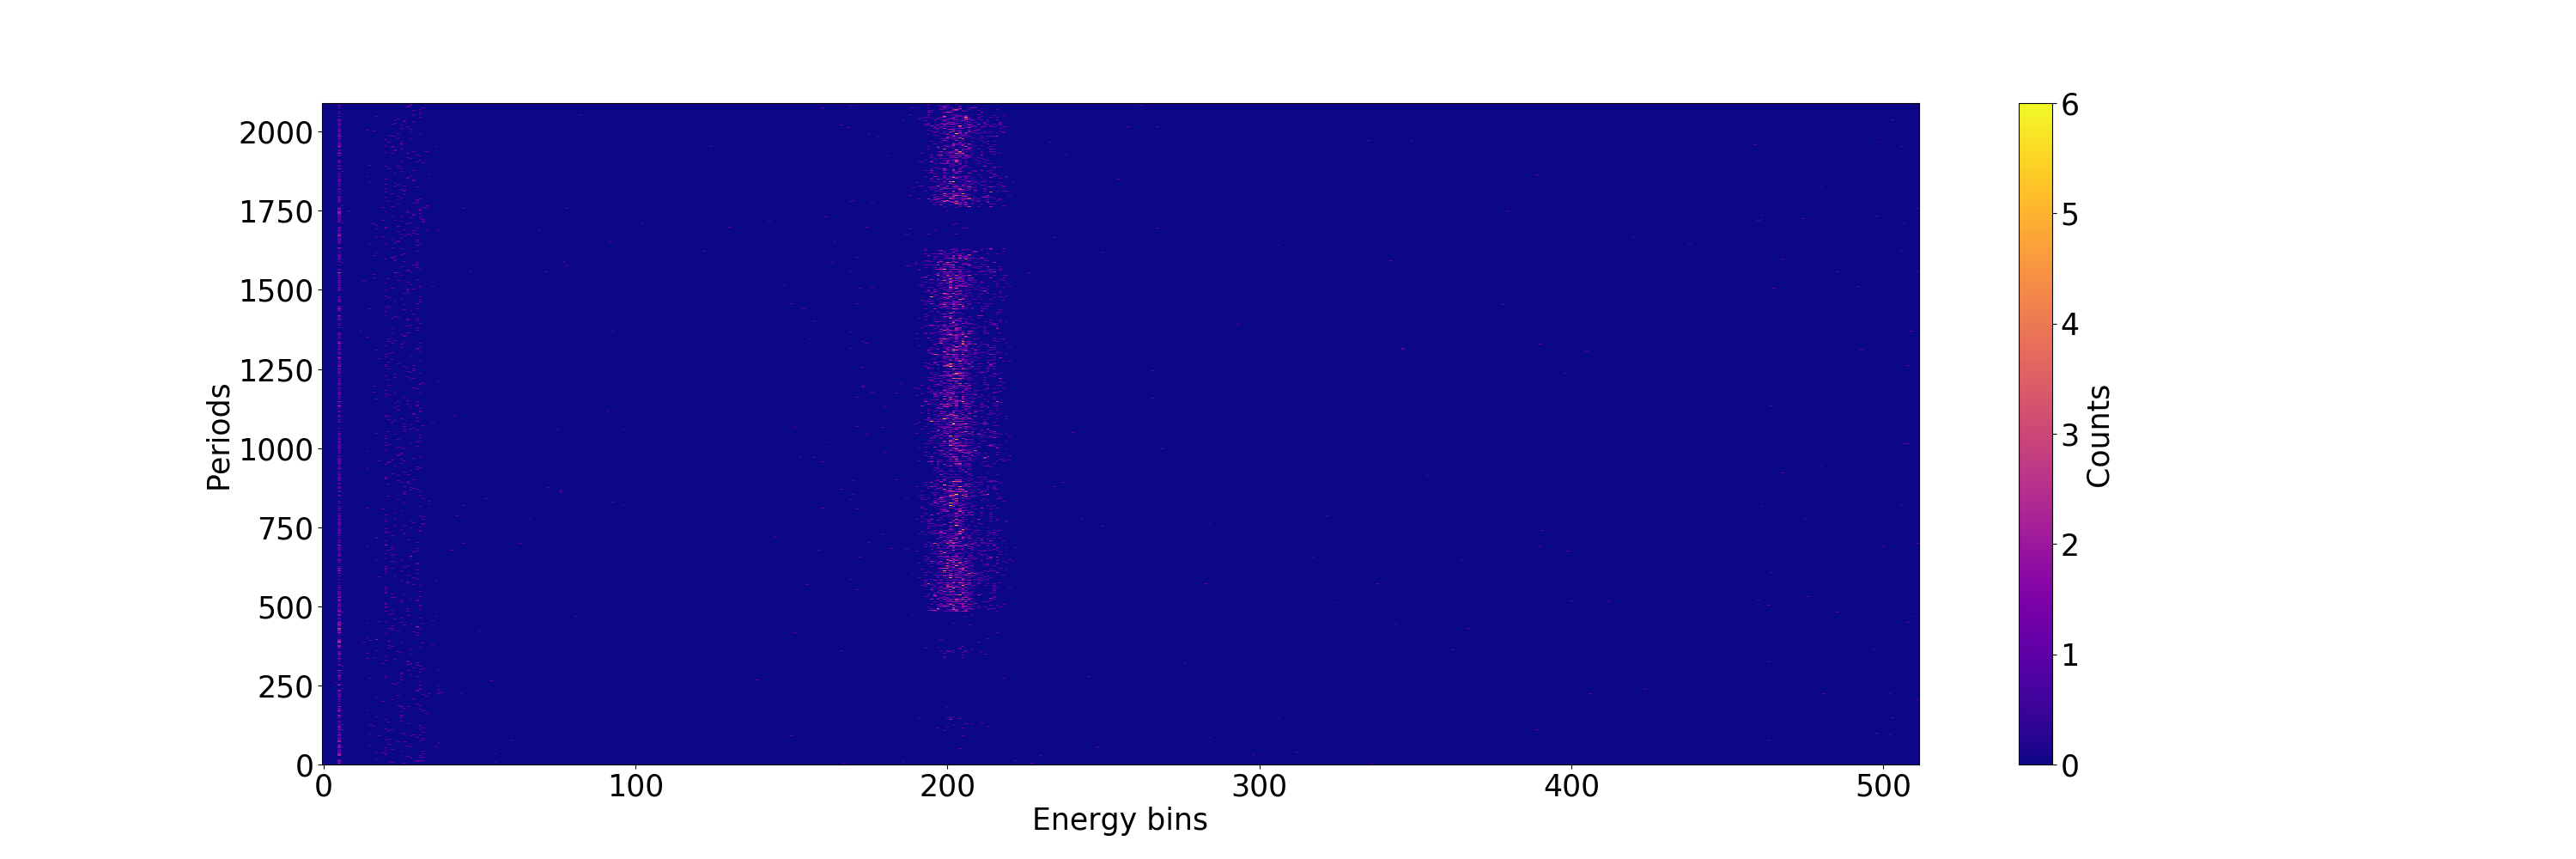

In [7]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 25}

matplotlib.rc('font', **font)

figure(figsize=(30,10))
plot_stacked_histograms_image(binList, sect=0)
savefig("plotFigs/stackedHistogramImage.svg")

<IPython.core.display.Javascript object>


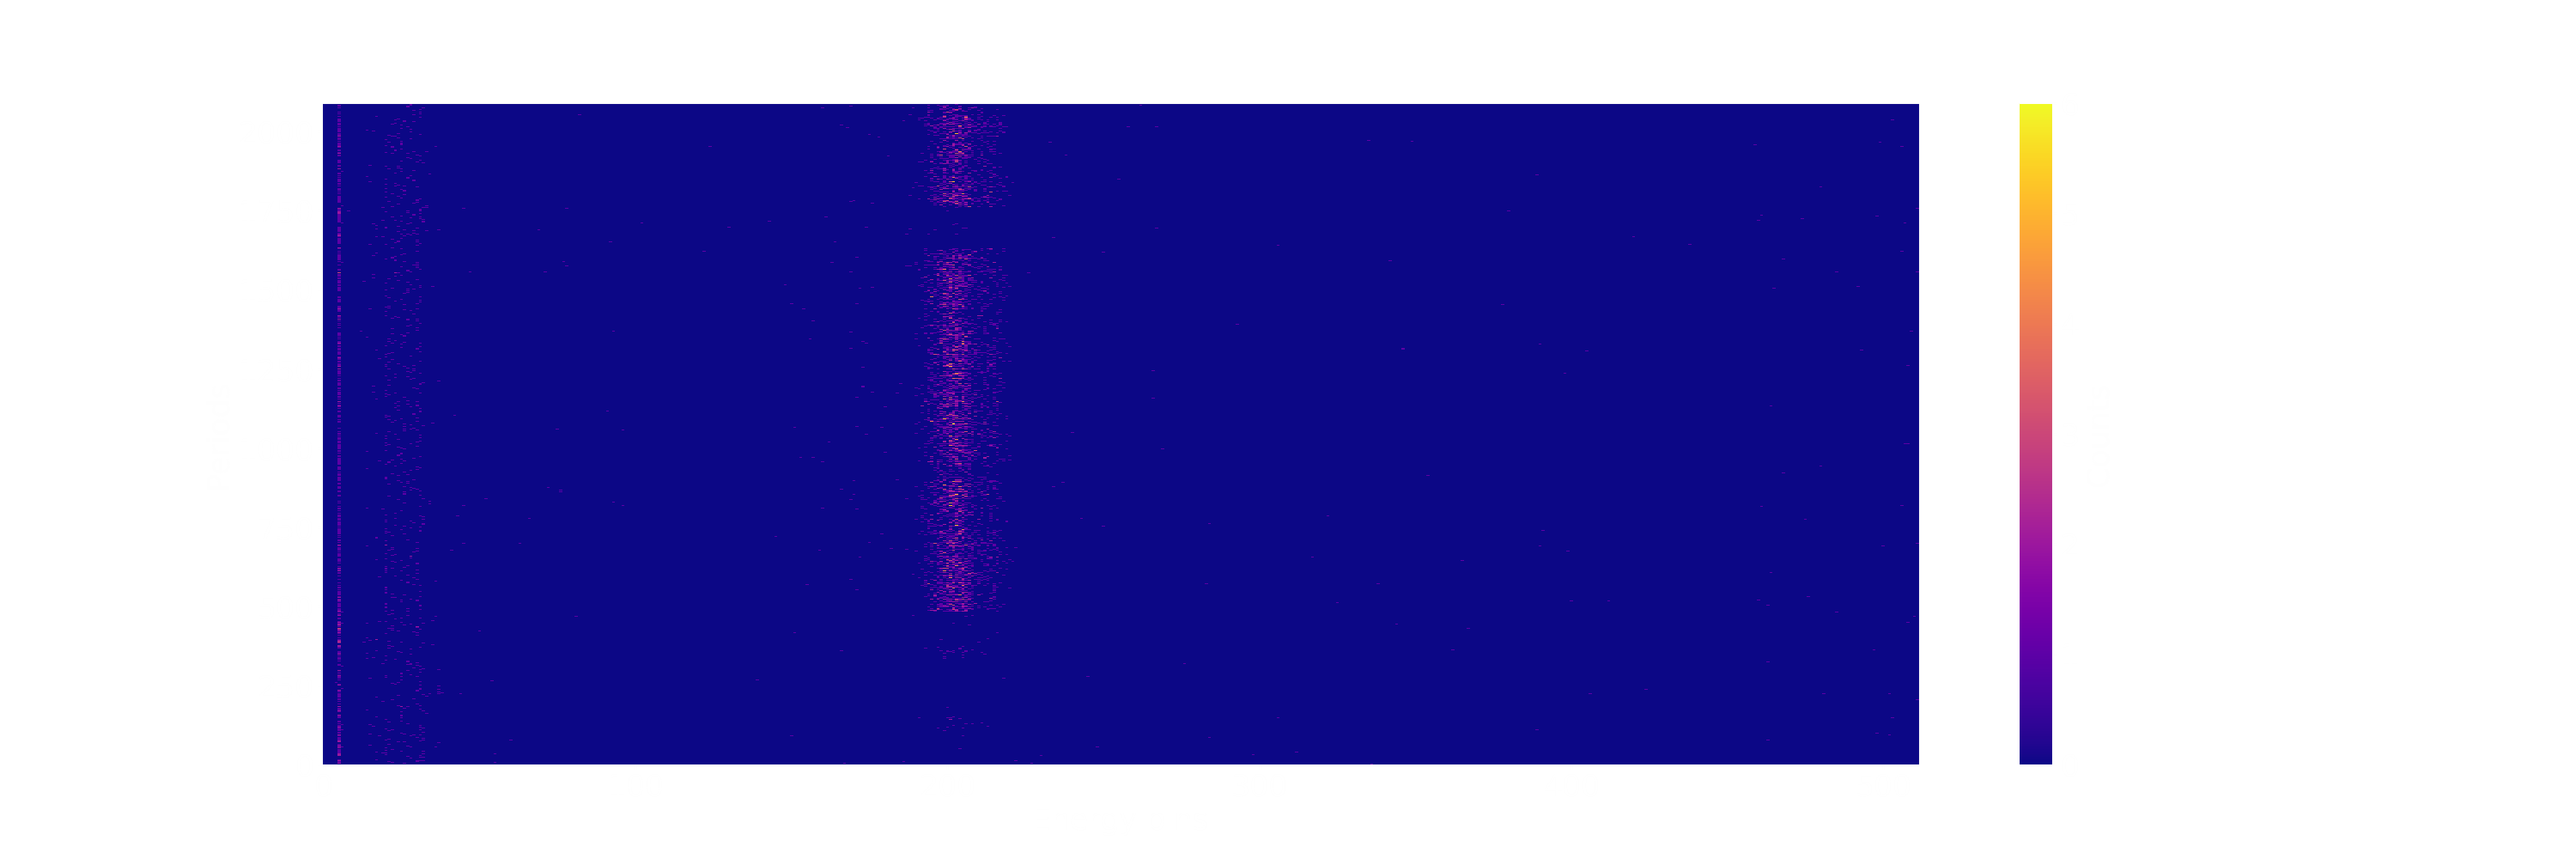

In [9]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 25}

matplotlib.rc('font', **font)

figure(figsize=(30,10))
with matplotlib.pyplot.style.context(("dark_background")):
    plot_stacked_histograms_image(binList, sect=0)
    savefig("plotFigs/stackedHistogramImageBlack.svg", transparent=True)

<IPython.core.display.Javascript object>


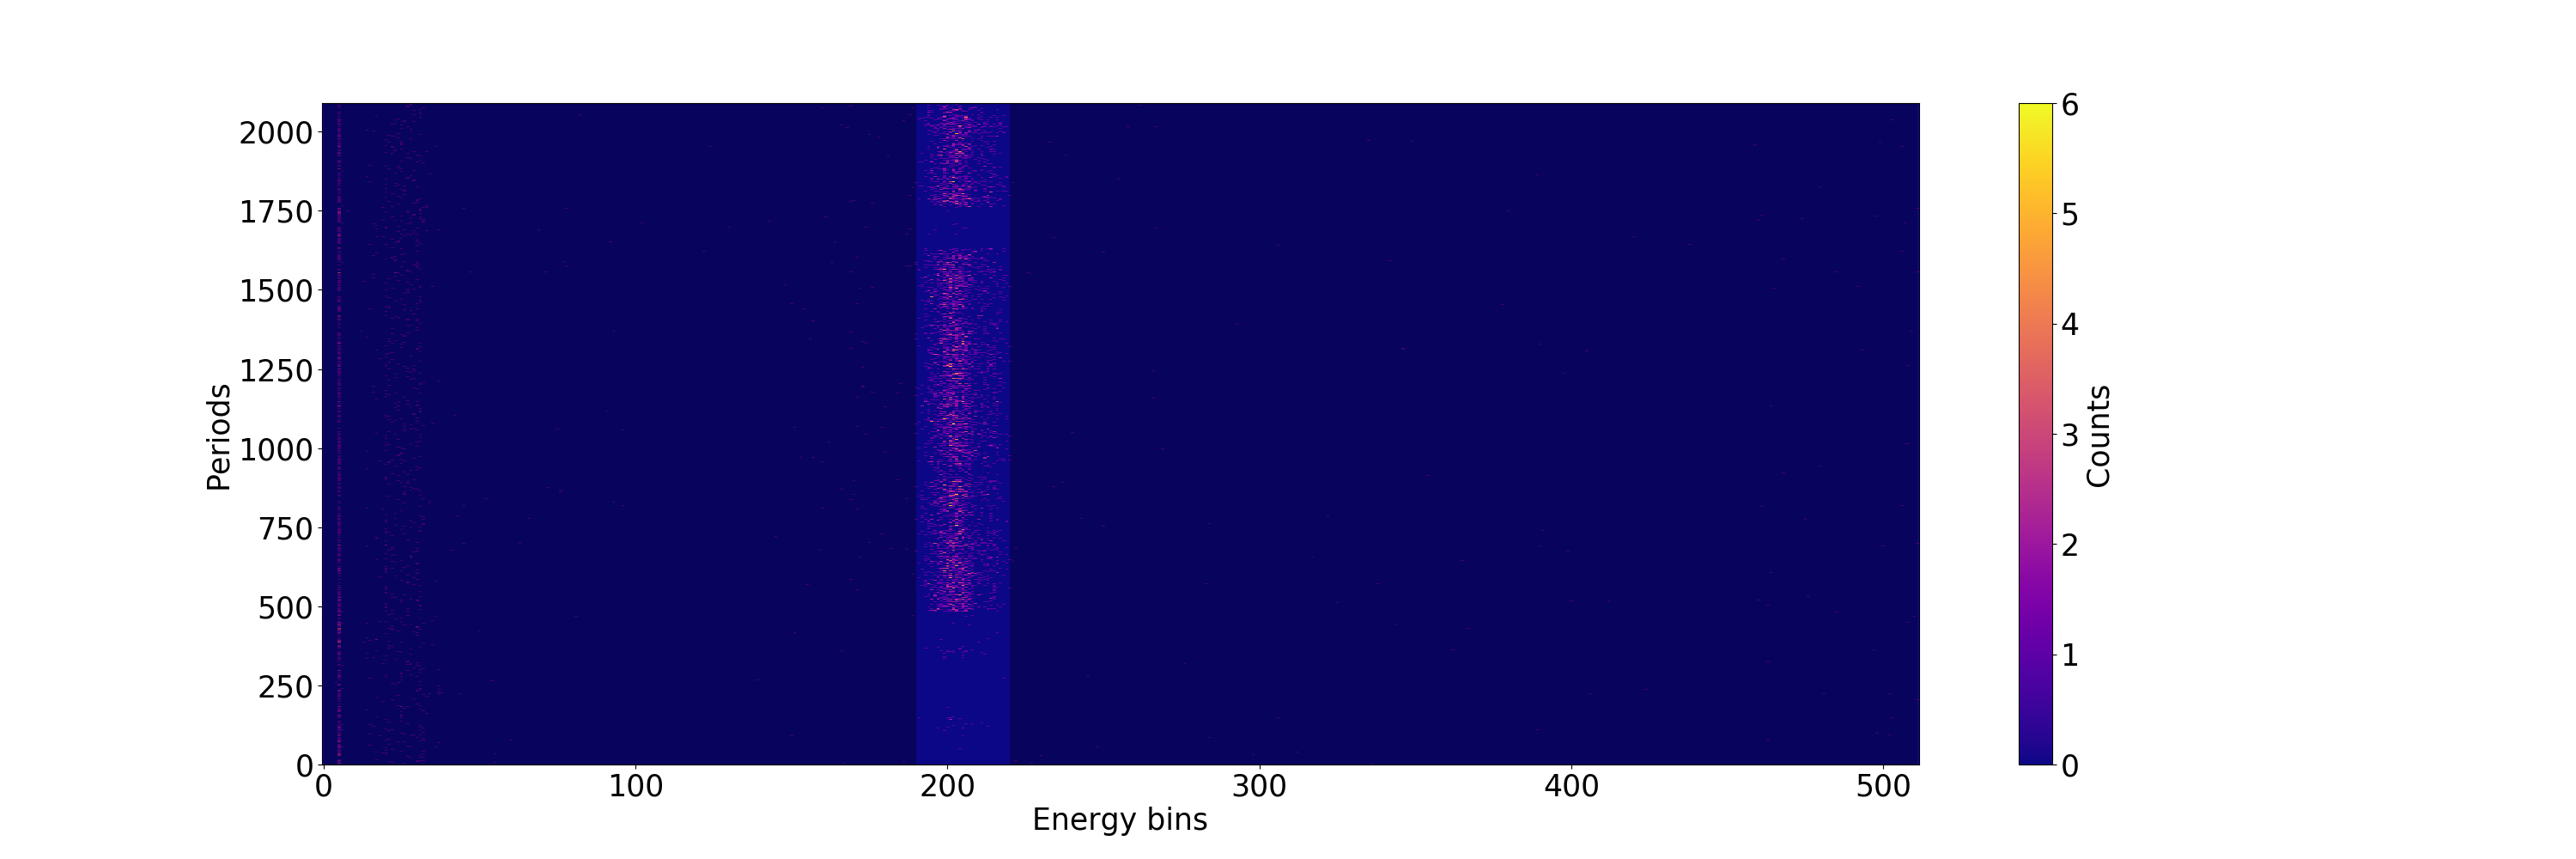

In [27]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 25}

matplotlib.rc('font', **font)

figure(figsize=(30,10))
plot_stacked_histograms_image(binList, sect=1)
c = 0
for i in binList:
    #plot(range(a,b+1),ones(len(range(a,b+1)))*(i.shape[0])+c-1, color='cyan', alpha=.5)
    c += i.shape[0]
savefig("plotFigs/stackedHistogramImageSect.svg")

<IPython.core.display.Javascript object>


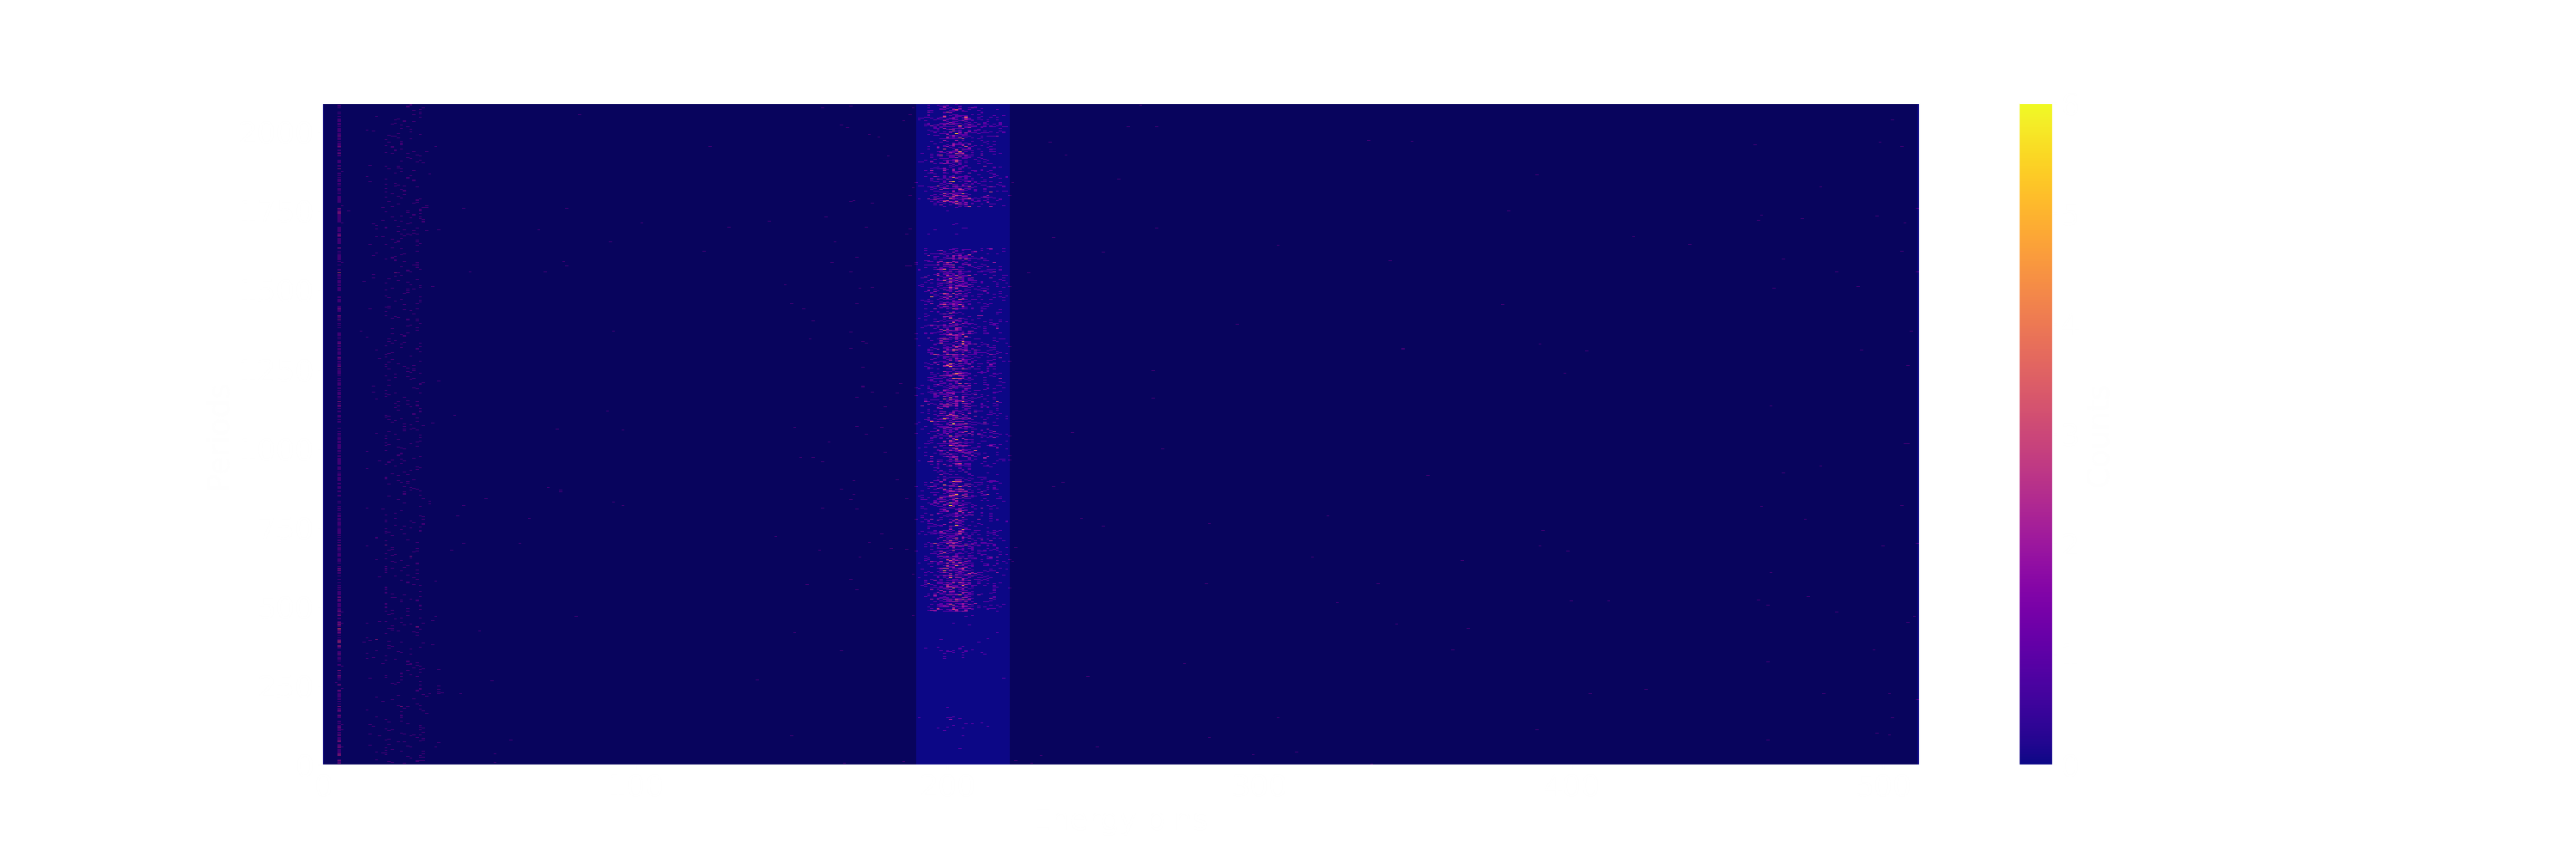

In [8]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 25}

matplotlib.rc('font', **font)

figure(figsize=(30,10))
with matplotlib.pyplot.style.context(("dark_background")):
    plot_stacked_histograms_image(binList, sect=1)
    savefig("plotFigs/stackedHistogramImageSectBlack.svg", transparent=True)

<IPython.core.display.Javascript object>


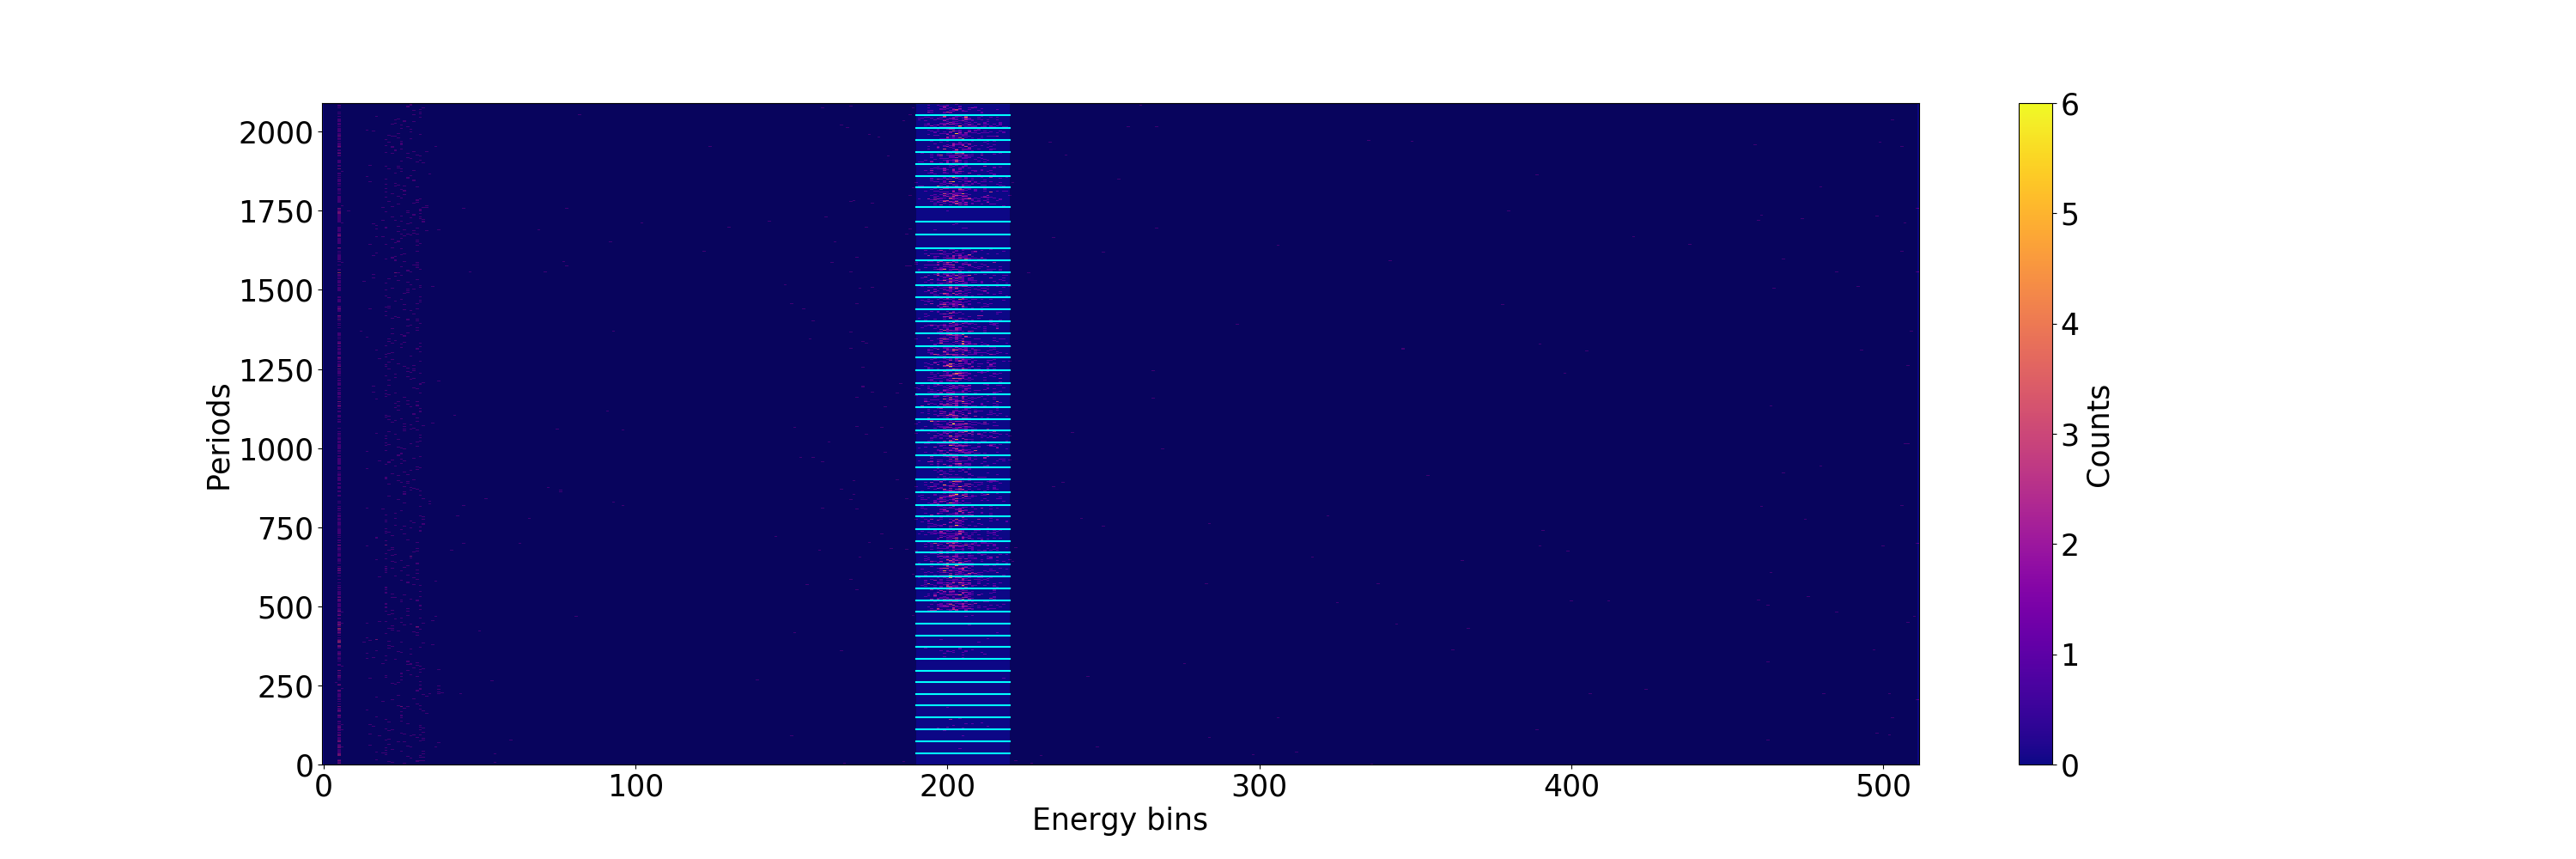

In [19]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 25}

matplotlib.rc('font', **font)

figure(figsize=(30,10))
plot_stacked_histograms_image(binList, sect=1)
c = 0
for i in binList:
    plot(range(a,b+1),ones(len(range(a,b+1)))*(i.shape[0])+c-1, color='cyan', alpha=1)
    c += i.shape[0]
savefig("plotFigs/stackedHistogramImageDivided.svg")

<IPython.core.display.Javascript object>


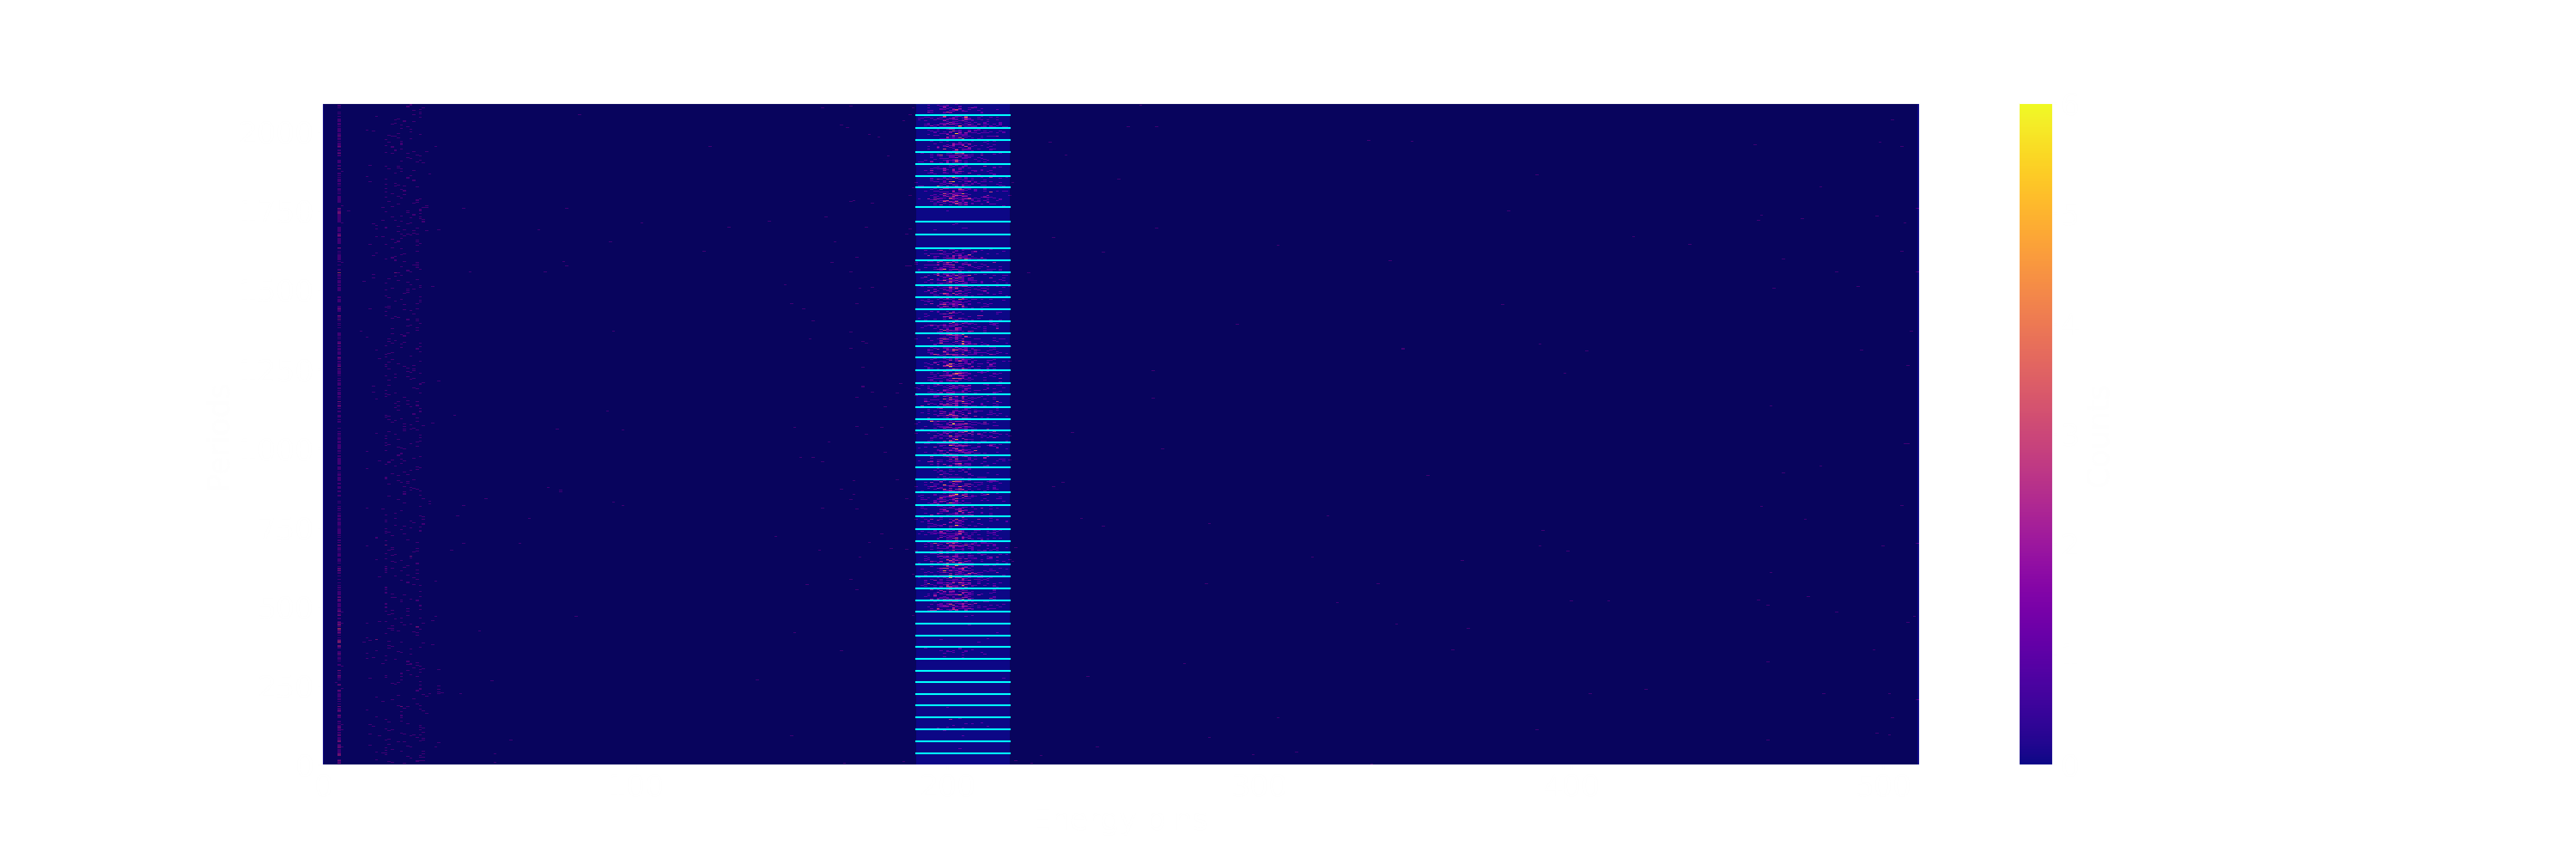

In [7]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 25}

matplotlib.rc('font', **font)
with matplotlib.pyplot.style.context(("dark_background")):
    figure(figsize=(30,10))
    plot_stacked_histograms_image(binList, sect=1)
    c = 0
    for i in binList:
        plot(range(a,b+1),ones(len(range(a,b+1)))*(i.shape[0])+c-1, color='cyan', alpha=1)
        c += i.shape[0]
    savefig("plotFigs/stackedHistogramImageDividedBlack.svg", transparent=True)

<IPython.core.display.Javascript object>


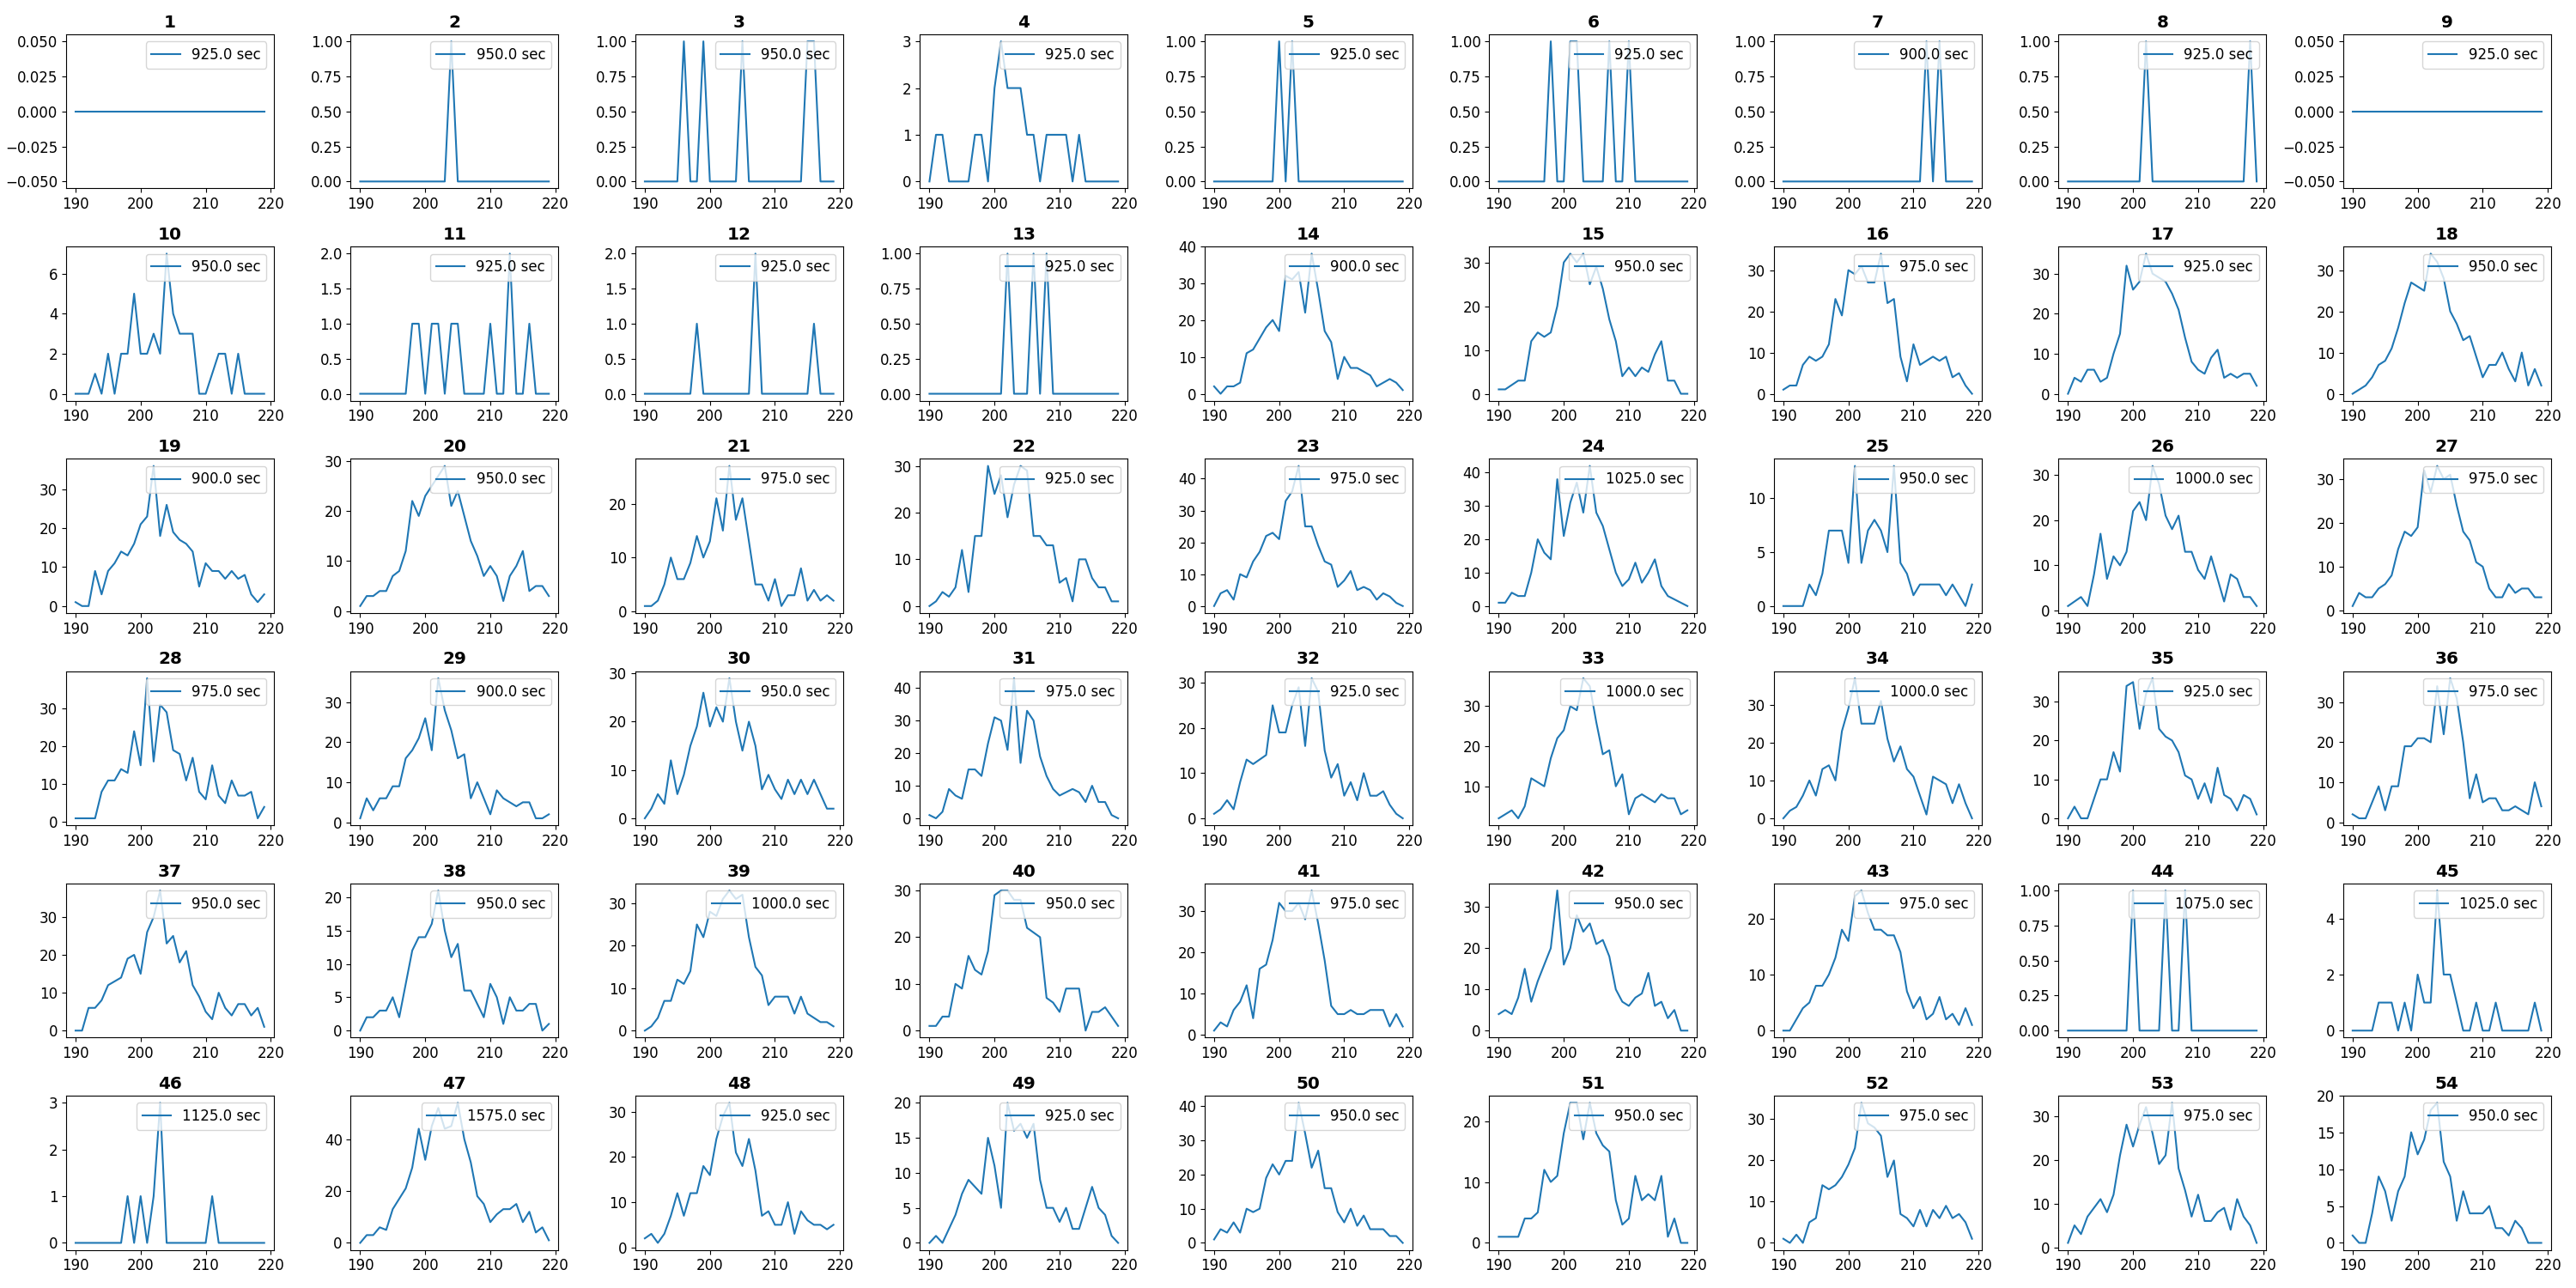

In [70]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(30,15))
matplotlib.rc('font', **font)
plot_all_histograms(eventsTimeList, removeBad=0, ordered=0)
tight_layout(pad=1)
savefig("plotFigs/allHistograms.svg")

<IPython.core.display.Javascript object>


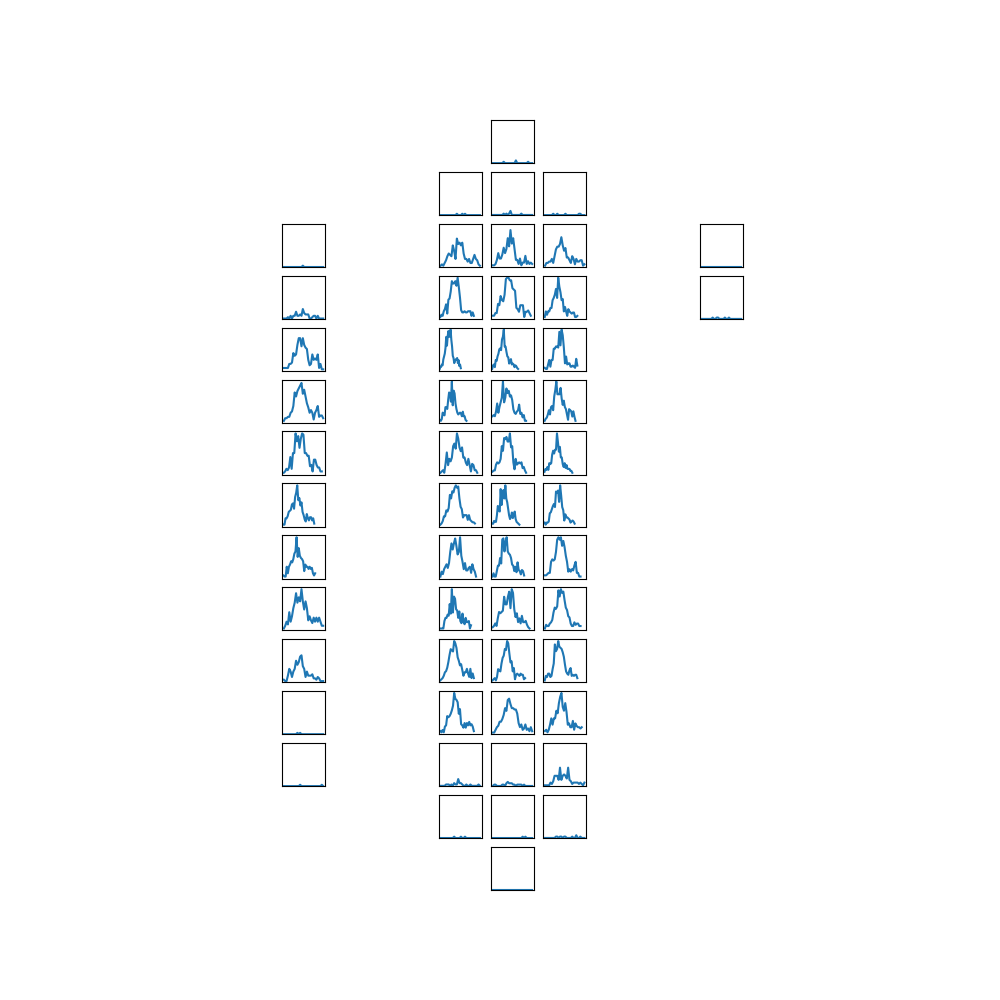

In [12]:
%matplotlib notebook
figure(figsize=(10,10))
plot_angular_response(azimuth,elevation, countsPerSec,plotHistograms=1,histograms=eventsTimeList, remover=0)
#tight_layout(pad=1)
savefig("plotFigs/angularResponseHistograms.svg")

<IPython.core.display.Javascript object>


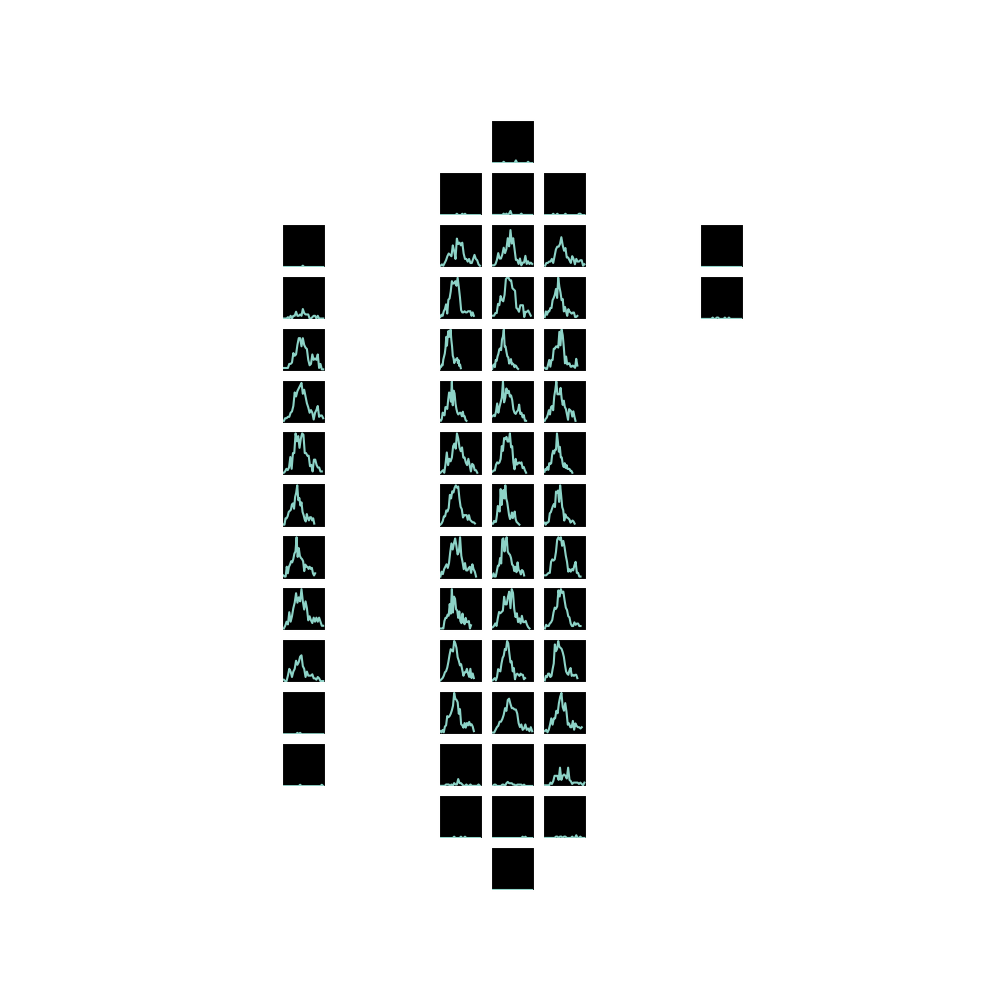

In [15]:
%matplotlib notebook
figure(figsize=(10,10))
with matplotlib.pyplot.style.context(("dark_background")):
    plot_angular_response(azimuth,elevation, countsPerSec,plotHistograms=1,histograms=eventsTimeList, remover=0)
    savefig("plotFigs/angularResponseHistogramsBlack.svg")

<IPython.core.display.Javascript object>


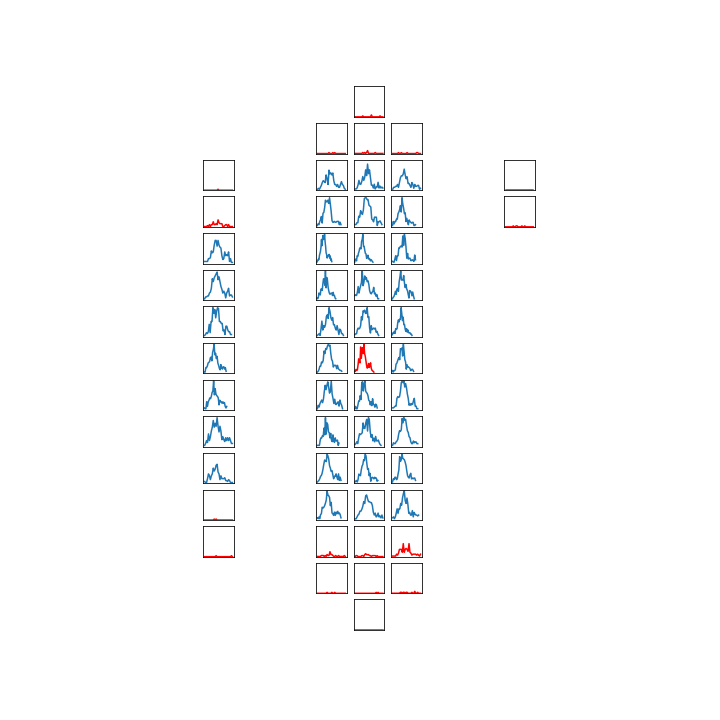

In [78]:
%matplotlib notebook
figure(figsize=(10,10))
plot_angular_response(azimuth,elevation, countsPerSec,plotHistograms=1,histograms=eventsTimeList, remover=1)
#tight_layout(pad=1)
savefig("plotFigs/angularResponseHistogramsRemoved.svg")

<IPython.core.display.Javascript object>


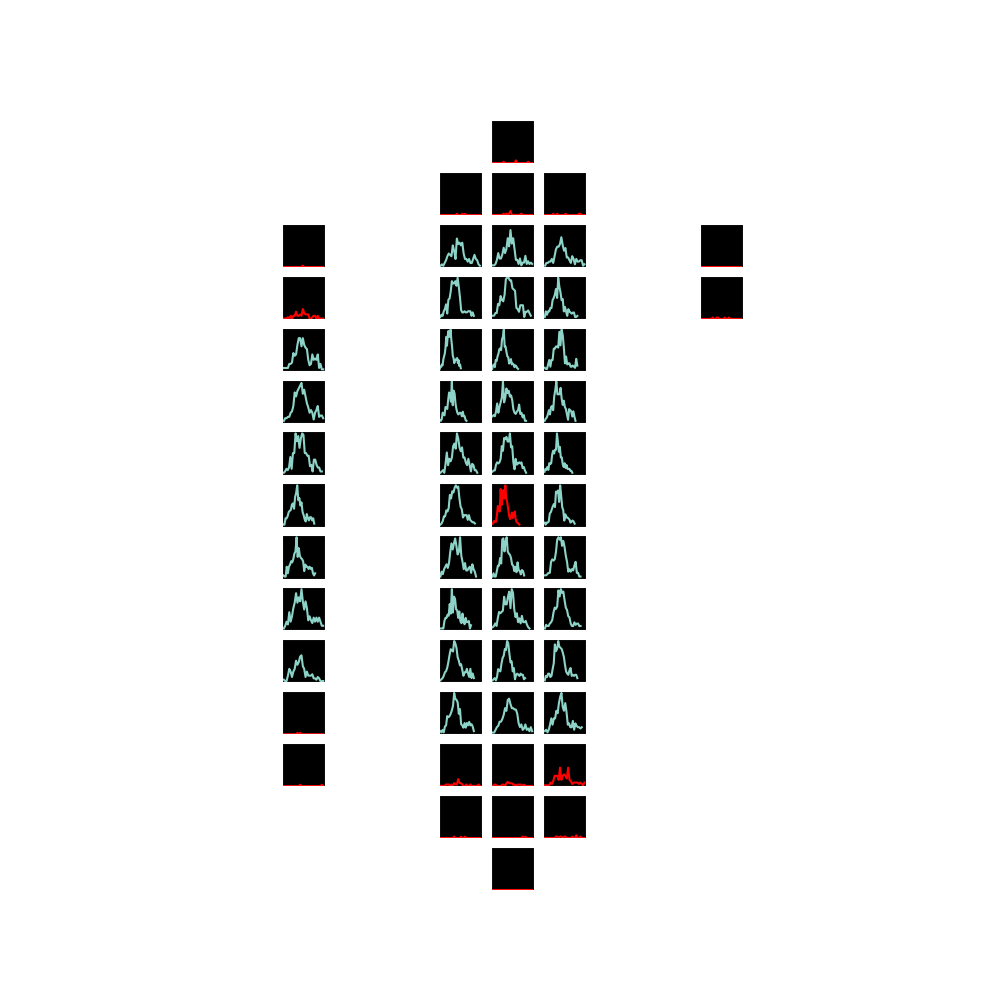

In [16]:
%matplotlib notebook
figure(figsize=(10,10))
with matplotlib.pyplot.style.context(("dark_background")):
    plot_angular_response(azimuth,elevation, countsPerSec,plotHistograms=1,histograms=eventsTimeList, remover=1)
    savefig("plotFigs/angularResponseHistogramsRemovedBlack.svg")

<IPython.core.display.Javascript object>


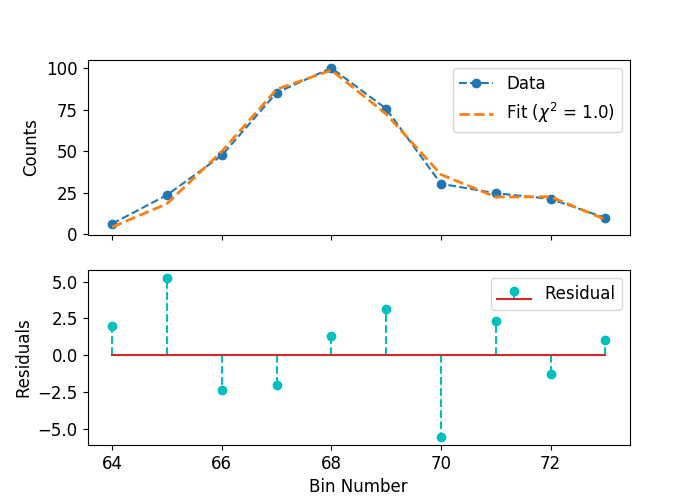

In [58]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(7,5))
matplotlib.rc('font', **font)
plot_histogram_fit_and_residual(eventsTimeList,noRMS=1,reduceBin=3,normalization=100,showPeaks=0)
savefig("plotFigs/allHistogramsFit.svg")

<IPython.core.display.Javascript object>


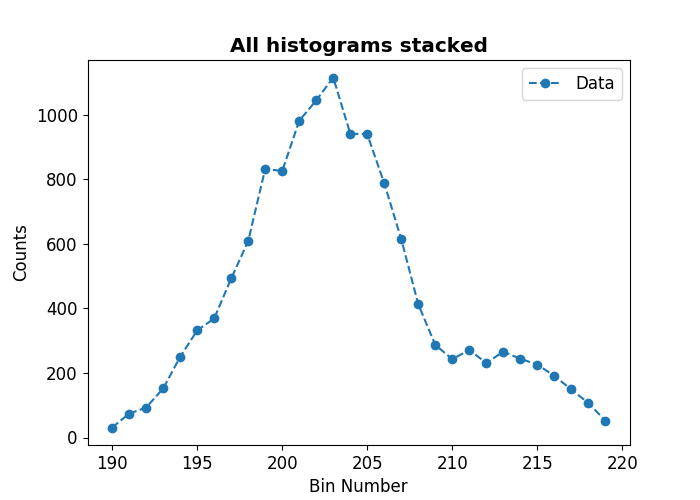

In [71]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(7,5))
fit_histograms(eventsTimeList, noRMS=1, showPeaks=0, noFit=1)
title("All histograms stacked", fontweight="bold")
savefig("plotFigs/allHistogramsStacked.svg", transparent =True)

<IPython.core.display.Javascript object>


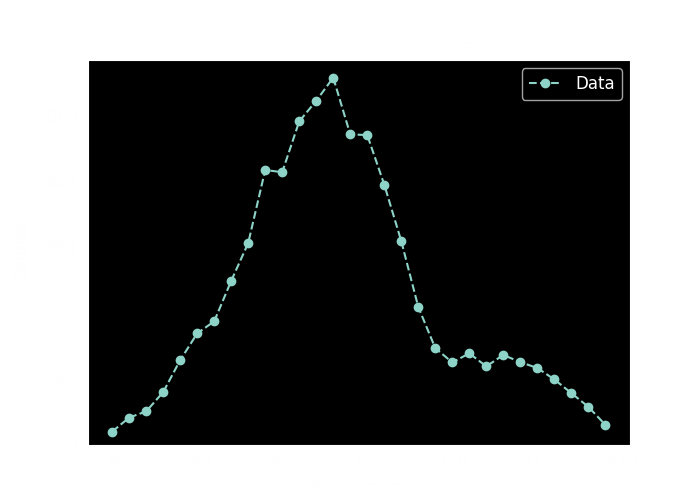

In [79]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(7,5))
with matplotlib.pyplot.style.context(("dark_background")):
    fit_histograms(eventsTimeList, noRMS=1, showPeaks=0, noFit=1)
    ylim(-10,1170)
    title("All histograms stacked", fontweight="bold")
    savefig("plotFigs/allHistogramsStackedBlack.svg",transparent=True)

<IPython.core.display.Javascript object>


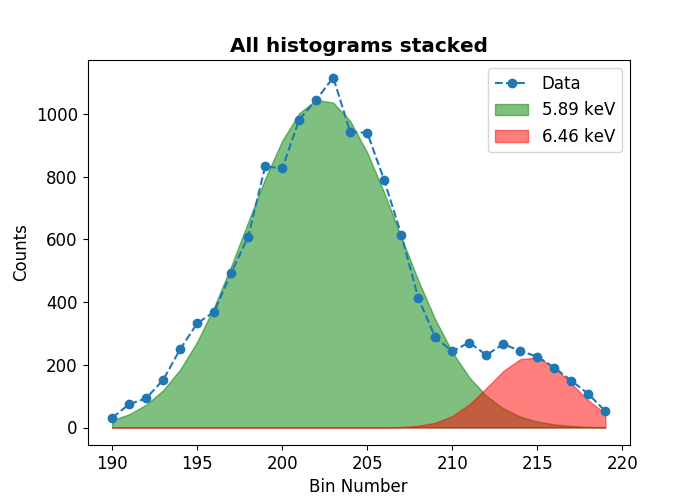

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in divide


In [73]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(7,5))
fit_histograms(eventsTimeList, noRMS=1, showPeaks=1, noFit=1)
title("All histograms stacked", fontweight="bold")
savefig("plotFigs/allHistogramsStackedPeaks.svg", transparent =True)

<IPython.core.display.Javascript object>


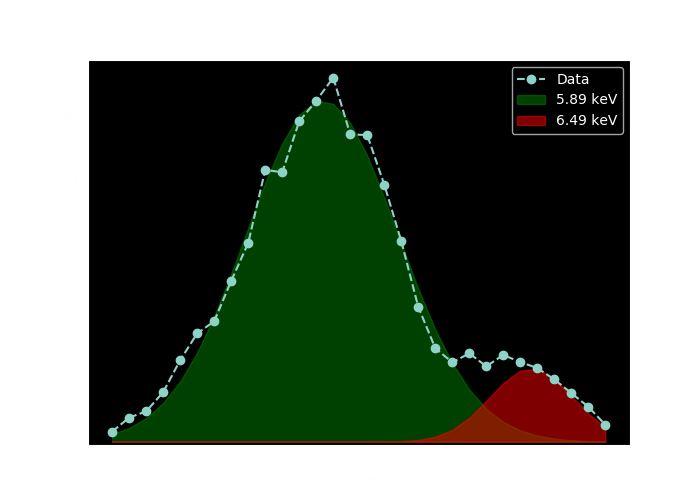

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in divide


In [5]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(7,5))
with matplotlib.pyplot.style.context(("dark_background")):
    fit_histograms(eventsTimeList, noRMS=1, showPeaks=1, noFit=1)
    ylim(-10,1170)
    title("All histograms stacked", fontweight="bold")
    savefig("plotFigs/allHistogramsStackedPeaksBlack.svg",transparent=True)

<IPython.core.display.Javascript object>


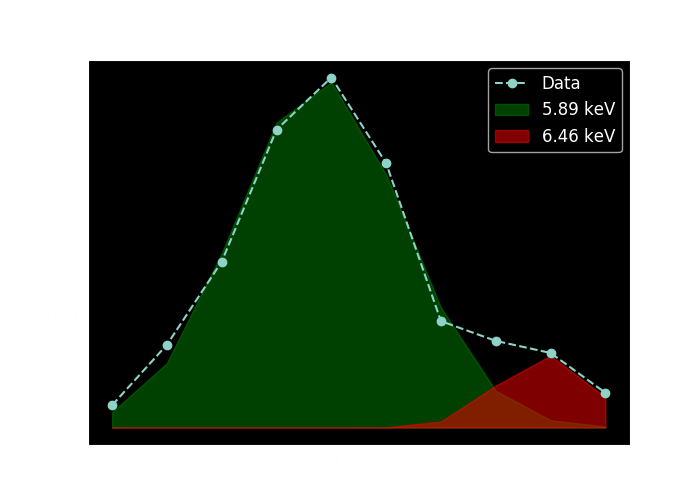

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in divide


In [82]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(7,5))
with matplotlib.pyplot.style.context(("dark_background")):
    fit_histograms(eventsTimeList, noRMS=1, showPeaks=1, noFit=1, reduceBin=3)
    #ylim(-10,1170)
    title("All histograms stacked", fontweight="bold")
    #savefig("plotFigs/allHistogramsStackedPeaksBlack.svg",transparent=True)

<IPython.core.display.Javascript object>


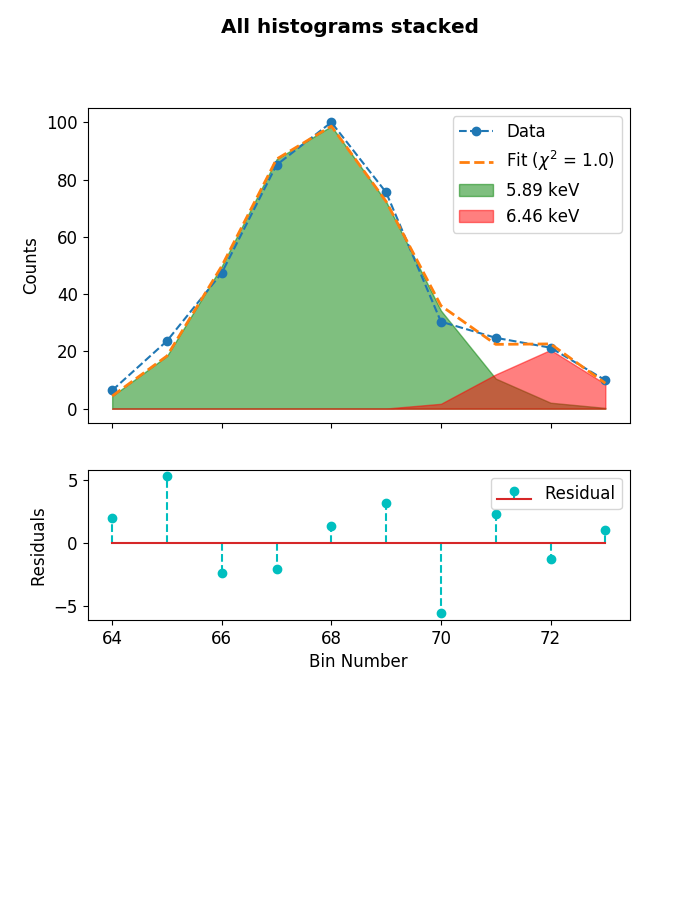

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in divide


In [96]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(7,9))
matplotlib.rc('font', **font)
plot_histogram_fit_and_residual(eventsTimeList,noRMS=1,reduceBin=3,normalization=100,showPeaks=1)
suptitle("All histograms stacked", fontweight="bold")
savefig("plotFigs/allHistogramsFitPeaks.svg")

<IPython.core.display.Javascript object>


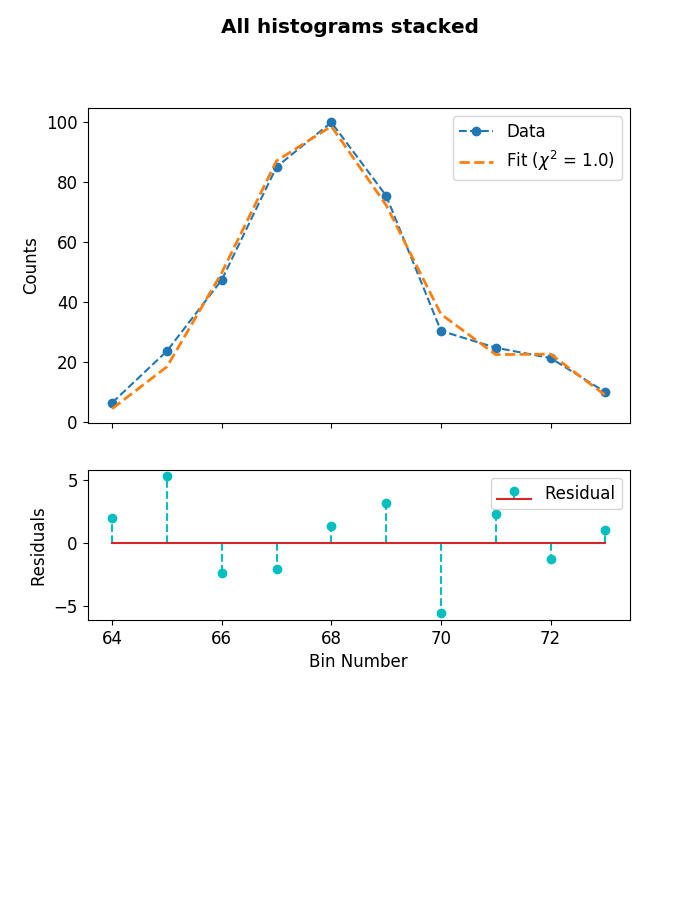

In [97]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(7,9))
matplotlib.rc('font', **font)
plot_histogram_fit_and_residual(eventsTimeList,noRMS=1,reduceBin=3,normalization=100,showPeaks=0)
suptitle("All histograms stacked", fontweight="bold")
savefig("plotFigs/allHistogramsFit.svg")

<IPython.core.display.Javascript object>


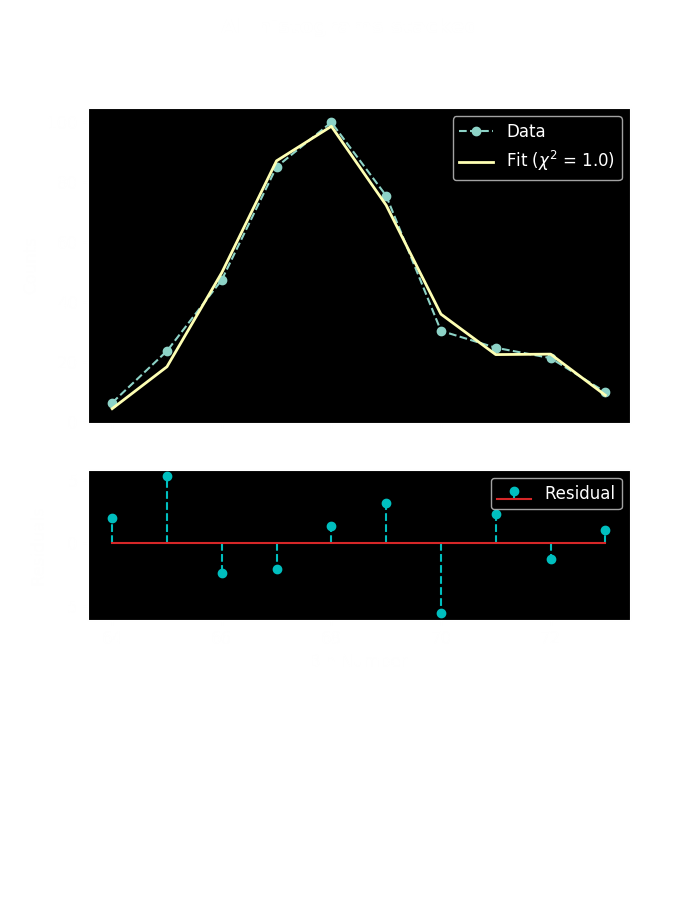

In [100]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(7,9))
matplotlib.rc('font', **font)
with matplotlib.pyplot.style.context(("dark_background")):
    plot_histogram_fit_and_residual(eventsTimeList,noRMS=1,reduceBin=3,normalization=100,showPeaks=0)
    suptitle("All histograms stacked", fontweight="bold")
    savefig("plotFigs/allHistogramsFitBlack.svg", transparent=True)

<IPython.core.display.Javascript object>


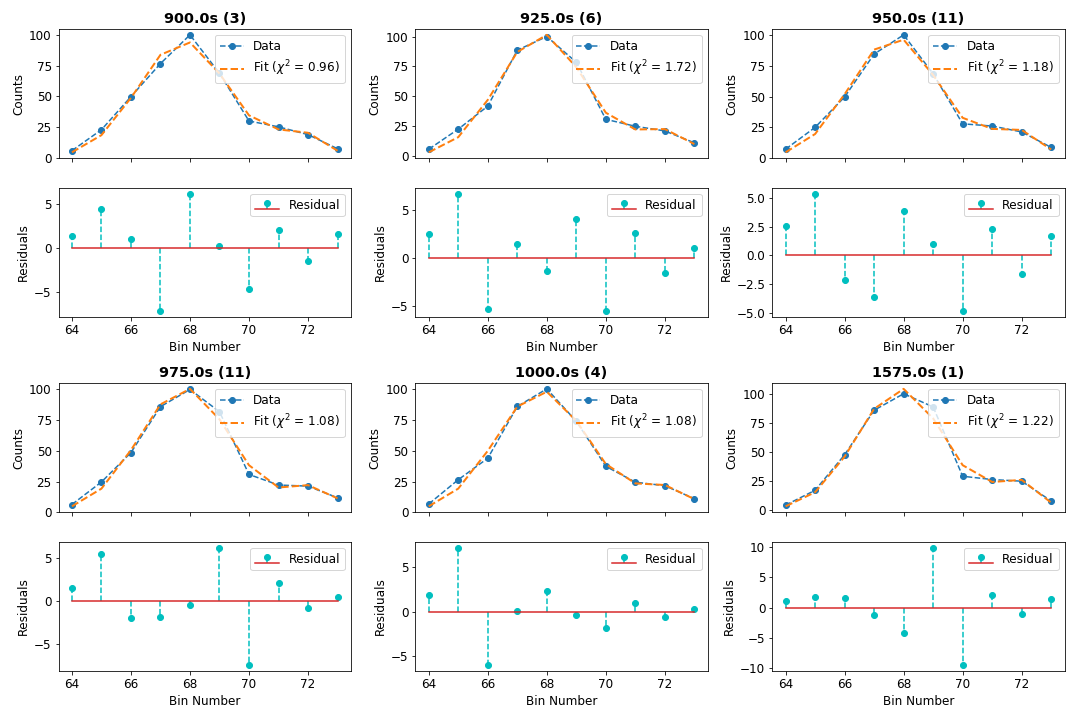

37
6
6
6
6
6
6


In [119]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(15,10))
matplotlib.rc('font', **font)
plot_histogram_fit_and_residual(eventsTimeList, reduceBin=3, normalization=100, noRMS=1, groupByTime=1, remover=1)
tight_layout(pad=1)
savefig("plotFigs/allHistogramsFitByTime.svg")

<IPython.core.display.Javascript object>


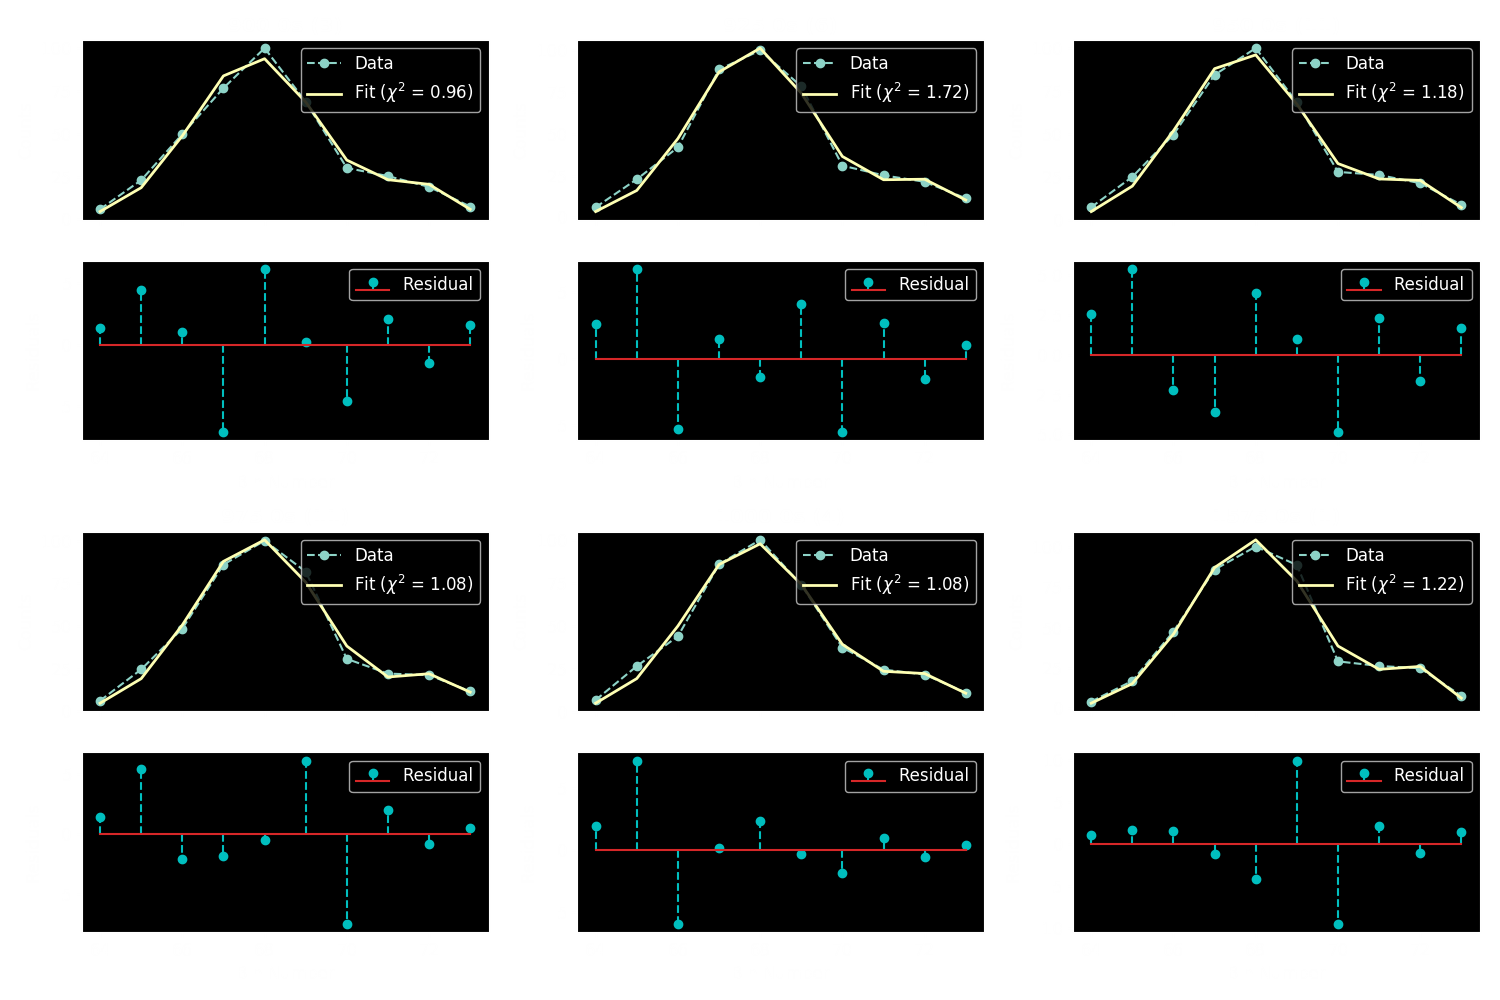

37
6
6
6
6
6
6


In [102]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(15,10))
matplotlib.rc('font', **font)
with matplotlib.pyplot.style.context(("dark_background")):
    plot_histogram_fit_and_residual(eventsTimeList, reduceBin=3, normalization=100, noRMS=1, groupByTime=1, remover=1)
    tight_layout(pad=1)
    savefig("plotFigs/allHistogramsFitByTimeBlack.svg", transparent=True)

<IPython.core.display.Javascript object>


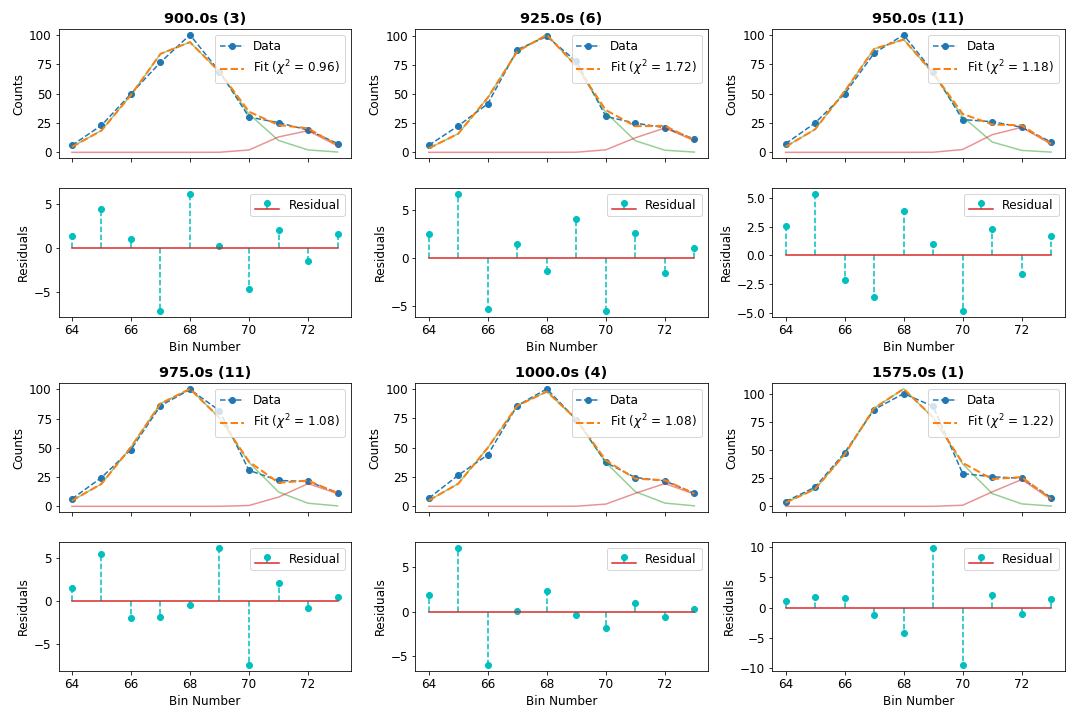

37
6
6
6


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in divide


6
6
6


In [120]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(15,10))
matplotlib.rc('font', **font)
plot_histogram_fit_and_residual(eventsTimeList, reduceBin=3, normalization=100, noRMS=1, groupByTime=1, remover=1,showPeaks=1)
tight_layout(pad=1)
savefig("plotFigs/allHistogramsFitByTimePeaks.svg")

<IPython.core.display.Javascript object>


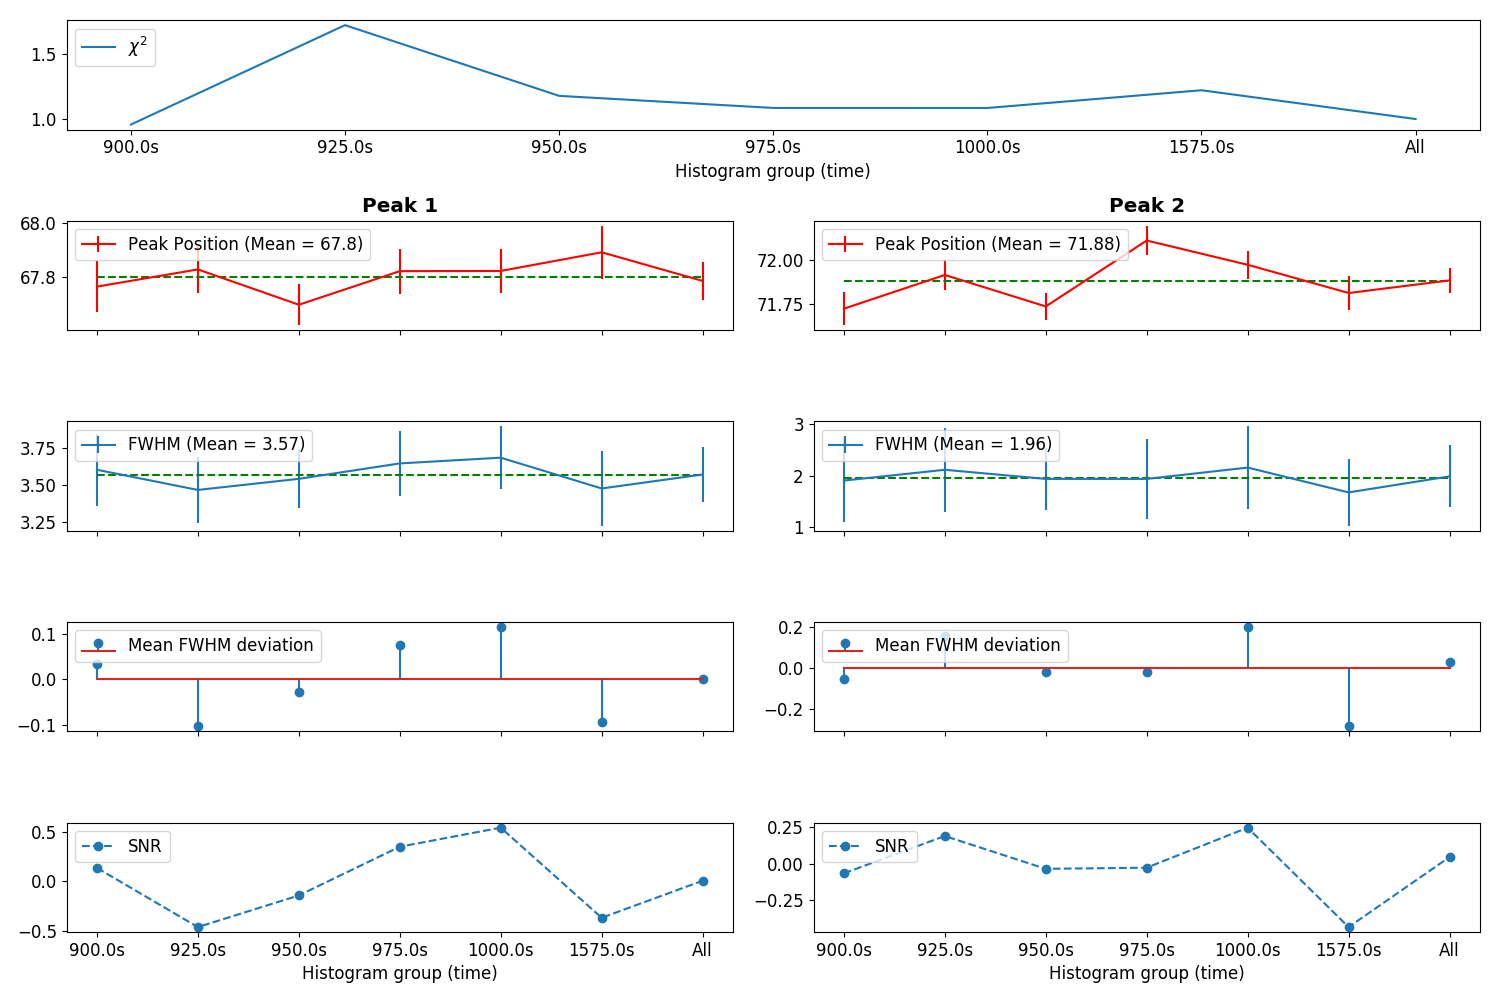

37
0.9986035930606373


In [33]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(15,10))
matplotlib.rc('font', **font)
plot_fit_parameters(eventsTimeList,noRMS=1,reduceBin=3, normalization=100, remover=1)
tight_layout(pad=1)
savefig("plotFigs/parameterEvolution.svg")

<IPython.core.display.Javascript object>


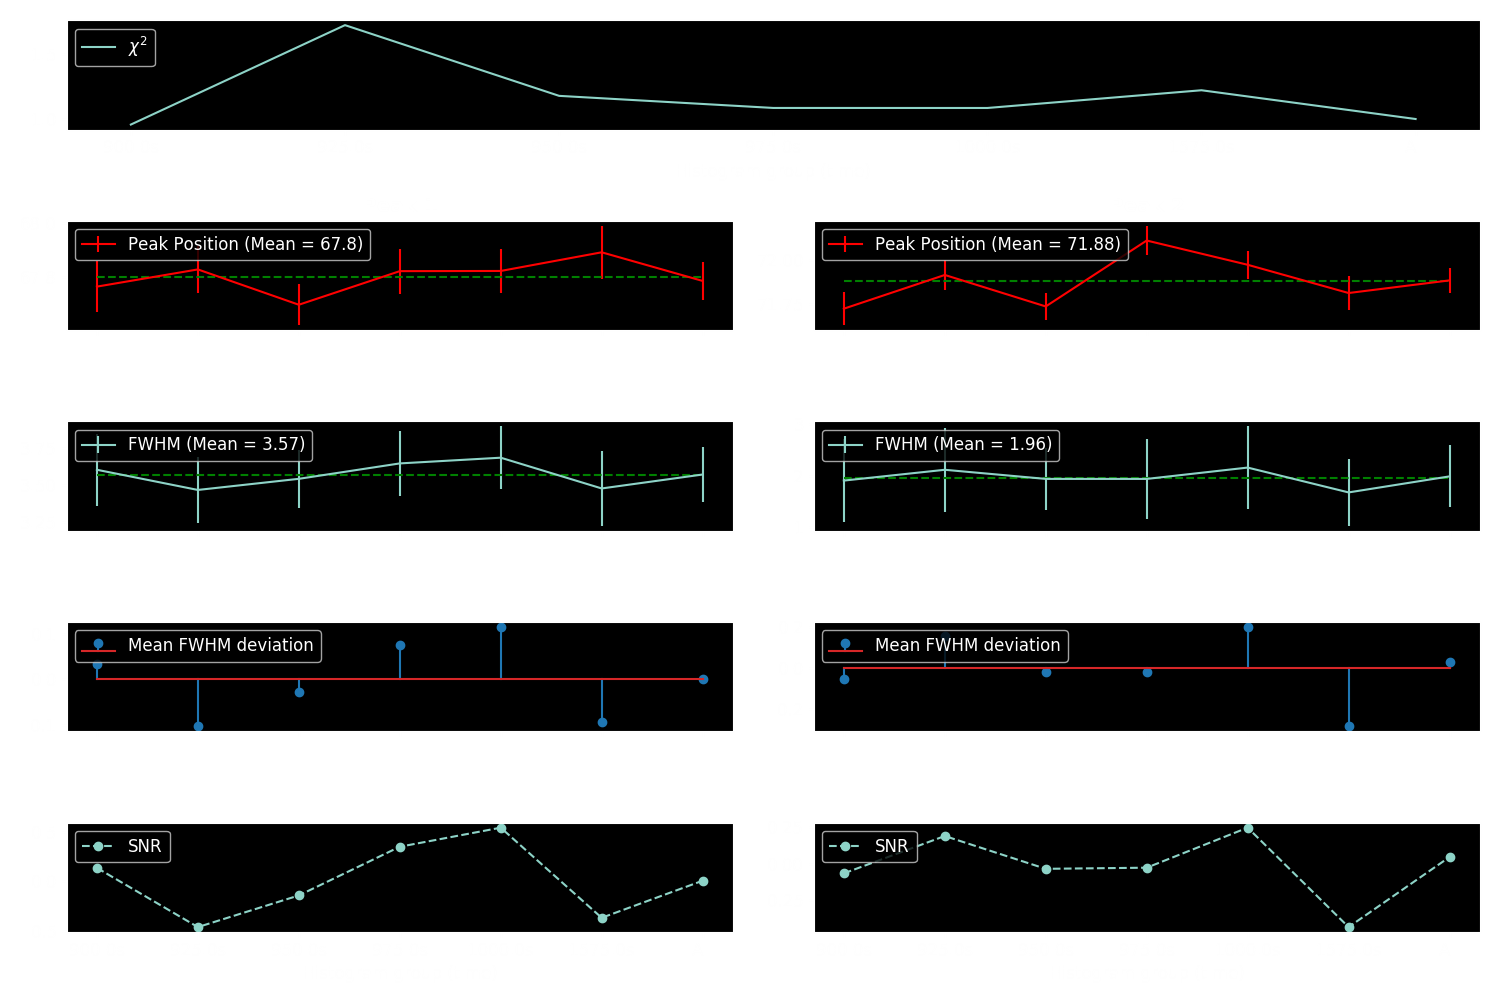

37
0.9986035930606373


In [34]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(15,10))
matplotlib.rc('font', **font)
with matplotlib.pyplot.style.context(("dark_background")):
    plot_fit_parameters(eventsTimeList,noRMS=1,reduceBin=3, normalization=100, remover=1)
    tight_layout(pad=1)
    savefig("plotFigs/parameterEvolutionBlack.svg", transparent=True)

<IPython.core.display.Javascript object>


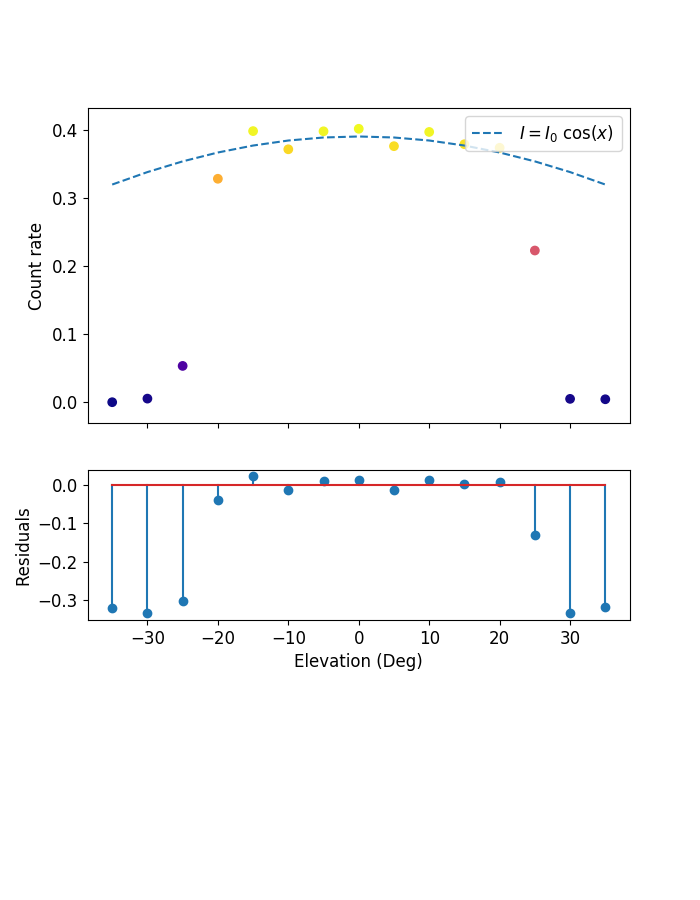

-35.0
25.0
30.0
-25.0
-20.0
20.0
-30.0
35.0
0.0
-5.0
5.0
-15.0
10.0
15.0
-10.0
a*cos(b*x+c)+d
a = 0.3906380787220165
6.947358666790324
18.277054326247256
Intensity decrease: 12.612206496518791%


In [42]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(7,9))
matplotlib.rc('font', **font)
plot_eventRate_vs_angle(countsPerSec,elevation, az=azimuth,plotCos=1, comb=1, area=0)
savefig("plotFigs/rateVSangle.svg", transparent=True)

<IPython.core.display.Javascript object>


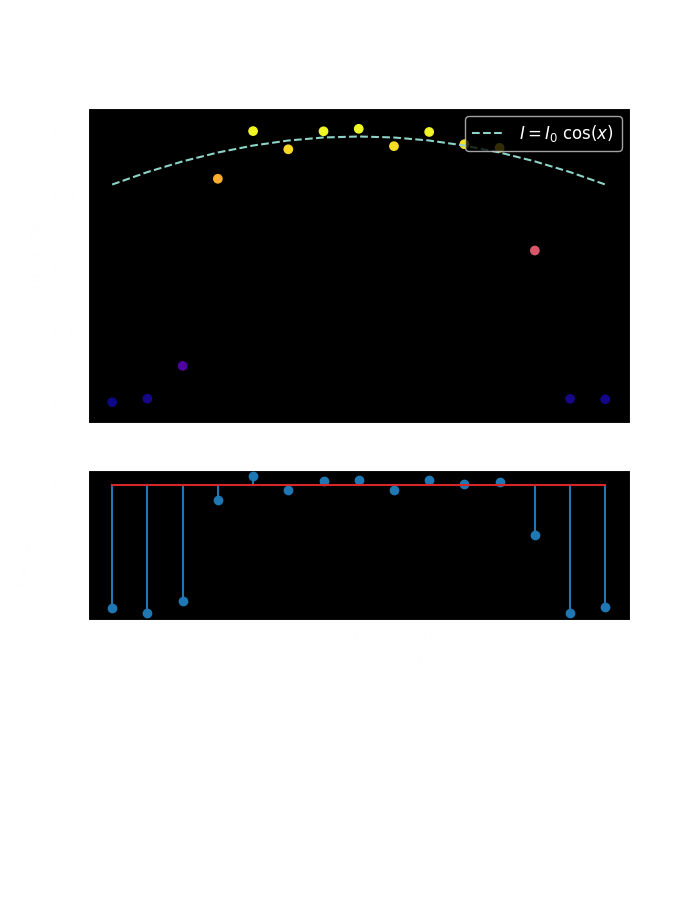

-35.0
25.0
30.0
-25.0
-20.0
20.0
-30.0
35.0
0.0
-5.0
5.0
-15.0
10.0
15.0
-10.0
a*cos(b*x+c)+d
a = 0.3906380787220165
6.947358666790324
18.277054326247256
Intensity decrease: 12.612206496518791%


In [41]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(7,9))
with matplotlib.pyplot.style.context(("dark_background")):
    matplotlib.rc('font', **font)
    plot_eventRate_vs_angle(countsPerSec,elevation, az=azimuth,plotCos=1, comb=1, area=0)
    savefig("plotFigs/rateVSangleBlack.svg",transparent=True)

<IPython.core.display.Javascript object>


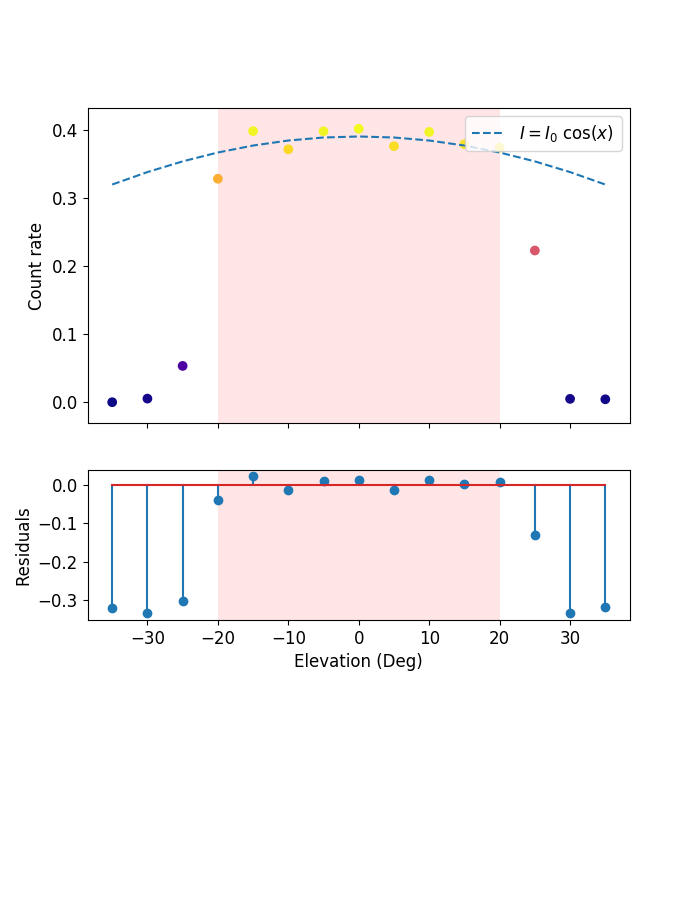

-35.0
25.0
30.0
-25.0
-20.0
20.0
-30.0
35.0
0.0
-5.0
5.0
-15.0
10.0
15.0
-10.0
a*cos(b*x+c)+d
a = 0.3906380787220165
6.947358666790324
18.277054326247256
Intensity decrease: 12.612206496518791%


In [43]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(7,9))
matplotlib.rc('font', **font)
plot_eventRate_vs_angle(countsPerSec,elevation, az=azimuth,plotCos=1, comb=1, area=1)
savefig("plotFigs/rateVSangleArea.svg", transparent=True)

<IPython.core.display.Javascript object>


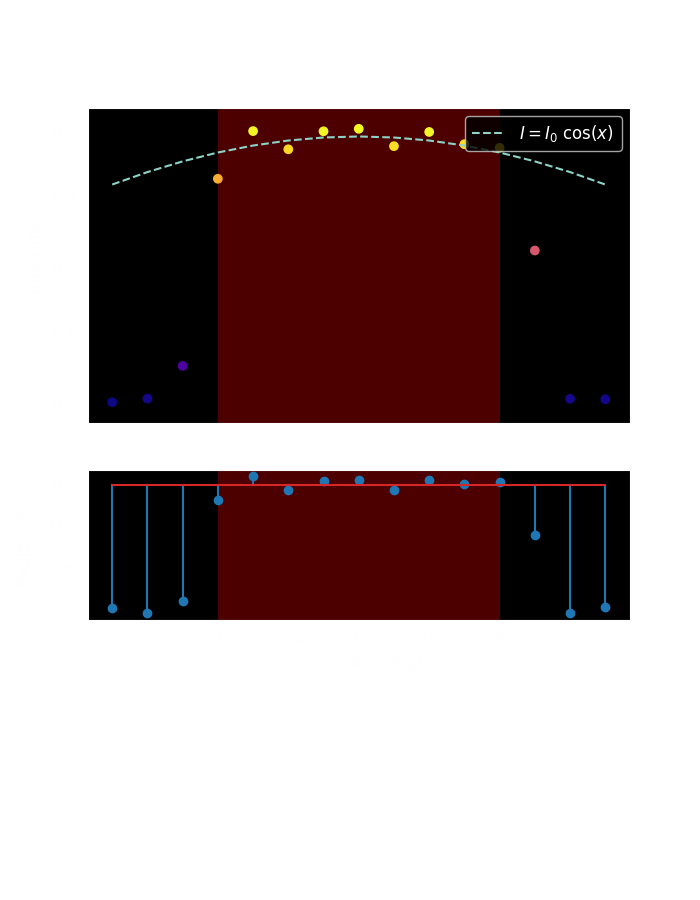

-35.0
25.0
30.0
-25.0
-20.0
20.0
-30.0
35.0
0.0
-5.0
5.0
-15.0
10.0
15.0
-10.0
a*cos(b*x+c)+d
a = 0.3906380787220165
6.947358666790324
18.277054326247256
Intensity decrease: 12.612206496518791%


In [46]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
figure(figsize=(7,9))
with matplotlib.pyplot.style.context(("dark_background")):
    matplotlib.rc('font', **font)
    plot_eventRate_vs_angle(countsPerSec,elevation, az=azimuth,plotCos=1, comb=1, area=1)
    savefig("plotFigs/rateVSangleAreaBlack.svg",transparent=True)

<IPython.core.display.Javascript object>


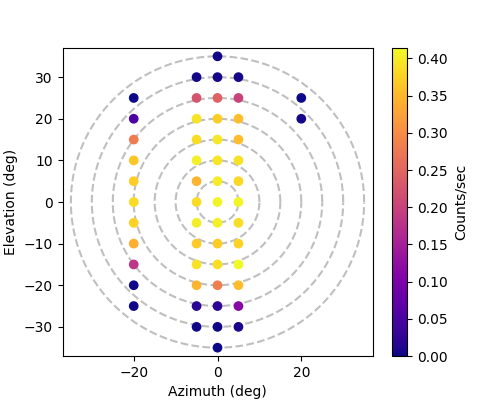

In [26]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 10}
figure(figsize=(5,4))
#subplot(111)
matplotlib.rc('font', **font)
plot_angular_response(az=azimuth,el=elevation,cps=countsPerSec,colorMapImage=0,highlightArea=0,centroid=0)
savefig("plotFigs/angResponse.svg",transparent=True)

<IPython.core.display.Javascript object>


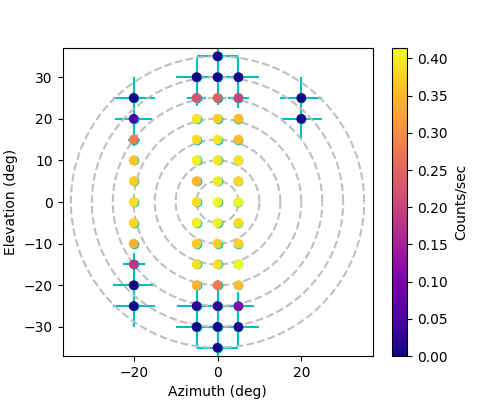

In [31]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 10}
figure(figsize=(5,4))
#subplot(111)
matplotlib.rc('font', **font)
plot_angular_response(az=azimuth,el=elevation,cps=countsPerSec,colorMapImage=0,highlightArea=0,centroid=0, errorBar=1)
savefig("plotFigs/angResponse.svg",transparent=True)

<IPython.core.display.Javascript object>


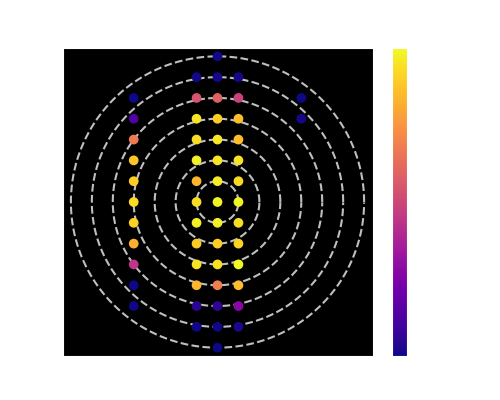

In [6]:
%matplotlib notebook
import matplotlib
with matplotlib.pyplot.style.context(("dark_background")):
    font = {'family' : 'normal',
            'weight' : 'regular',
            'size'   : 10}
    figure(figsize=(5,4))
    #subplot(111)
    matplotlib.rc('font', **font)
    plot_angular_response(az=azimuth,el=elevation,cps=countsPerSec,colorMapImage=0,highlightArea=0,centroid=0)
    savefig("plotFigs/angResponseBlack.svg",transparent=True)

<IPython.core.display.Javascript object>


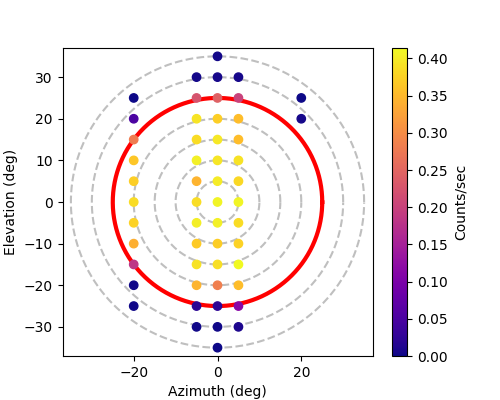

In [28]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 10}
figure(figsize=(5,4))
#subplot(111)
matplotlib.rc('font', **font)
plot_angular_response(az=azimuth,el=elevation,cps=countsPerSec,colorMapImage=0,highlightArea=1,centroid=0)
savefig("plotFigs/angResponseArea.svg",transparent=True)

<IPython.core.display.Javascript object>


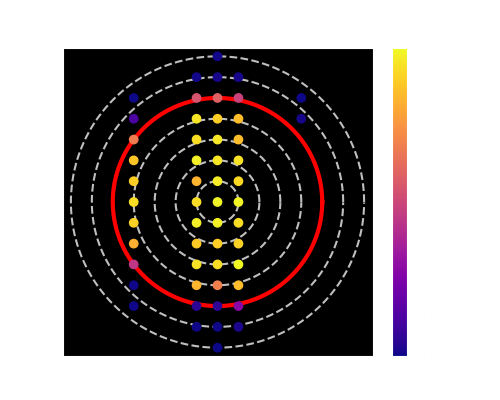

In [37]:
%matplotlib notebook
import matplotlib
with matplotlib.pyplot.style.context(("dark_background")):
    font = {'family' : 'normal',
            'weight' : 'regular',
            'size'   : 10}
    figure(figsize=(5,4))
    #subplot(111)
    matplotlib.rc('font', **font)
    plot_angular_response(az=azimuth,el=elevation,cps=countsPerSec,colorMapImage=0,highlightArea=1,centroid=0)
    savefig("plotFigs/angResponseAreaBlack.svg",transparent=True)

<IPython.core.display.Javascript object>


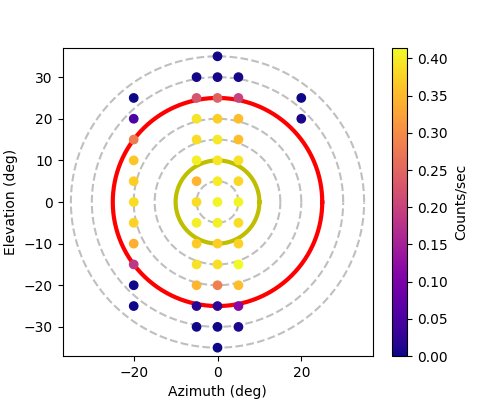

In [30]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 10}
figure(figsize=(5,4))
#subplot(111)
matplotlib.rc('font', **font)
plot_angular_response(az=azimuth,el=elevation,cps=countsPerSec,colorMapImage=0,highlightArea=1,centroid=1)
savefig("plotFigs/angResponseCent.svg",transparent=True)

<IPython.core.display.Javascript object>


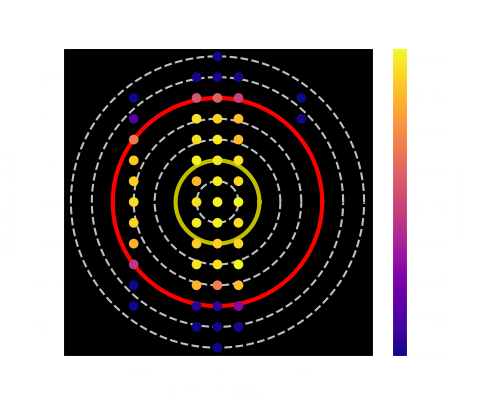

In [36]:
%matplotlib notebook
import matplotlib
with matplotlib.pyplot.style.context(("dark_background")):
    font = {'family' : 'normal',
            'weight' : 'regular',
            'size'   : 10}
    figure(figsize=(5,4))
    #subplot(111)
    matplotlib.rc('font', **font)
    plot_angular_response(az=azimuth,el=elevation,cps=countsPerSec,colorMapImage=0,highlightArea=1,centroid=1)
    savefig("plotFigs/angResponseCentBlack.svg",transparent=True)

<IPython.core.display.Javascript object>


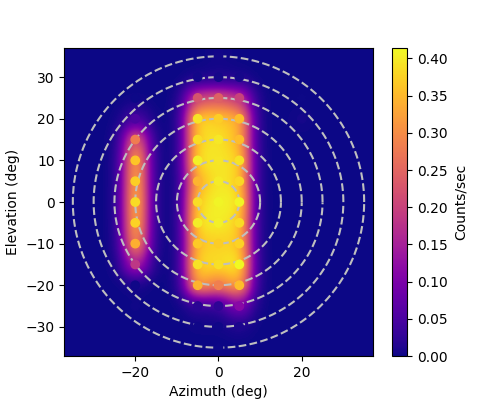

In [32]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 10}
figure(figsize=(5,4))
#subplot(111)
matplotlib.rc('font', **font)
plot_angular_response(az=azimuth,el=elevation,cps=countsPerSec,colorMapImage=1,highlightArea=0,centroid=0)
savefig("plotFigs/angResponseColor.svg",transparent=True)

<IPython.core.display.Javascript object>


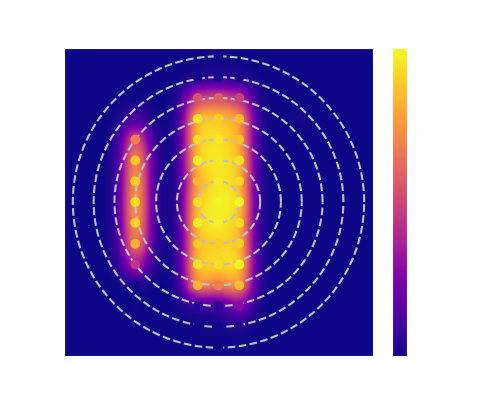

In [33]:
%matplotlib notebook
import matplotlib
with matplotlib.pyplot.style.context(("dark_background")):
    font = {'family' : 'normal',
            'weight' : 'regular',
            'size'   : 10}
    figure(figsize=(5,4))
    #subplot(111)
    matplotlib.rc('font', **font)
    plot_angular_response(az=azimuth,el=elevation,cps=countsPerSec,colorMapImage=1,highlightArea=0,centroid=0)
    savefig("plotFigs/angResponseColorBlack.svg",transparent=True)

<IPython.core.display.Javascript object>


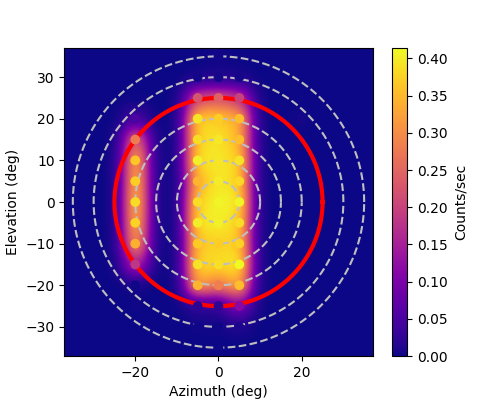

In [34]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 10}
figure(figsize=(5,4))
#subplot(111)
matplotlib.rc('font', **font)
plot_angular_response(az=azimuth,el=elevation,cps=countsPerSec,colorMapImage=1,highlightArea=1,centroid=0)
savefig("plotFigs/angResponseColorArea.svg",transparent=True)

<IPython.core.display.Javascript object>


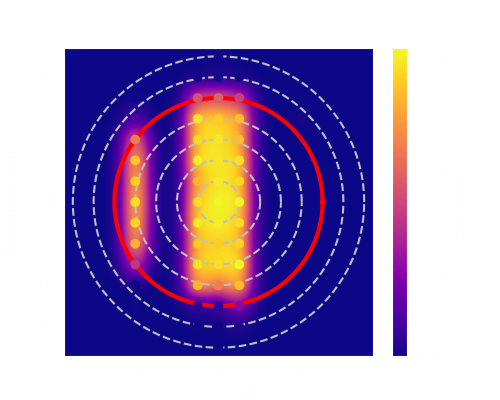

In [35]:
%matplotlib notebook
import matplotlib
with matplotlib.pyplot.style.context(("dark_background")):
    font = {'family' : 'normal',
            'weight' : 'regular',
            'size'   : 10}
    figure(figsize=(5,4))
    #subplot(111)
    matplotlib.rc('font', **font)
    plot_angular_response(az=azimuth,el=elevation,cps=countsPerSec,colorMapImage=1,highlightArea=1,centroid=0)
    savefig("plotFigs/angResponseColorAreaBlack.svg",transparent=True)

<IPython.core.display.Javascript object>


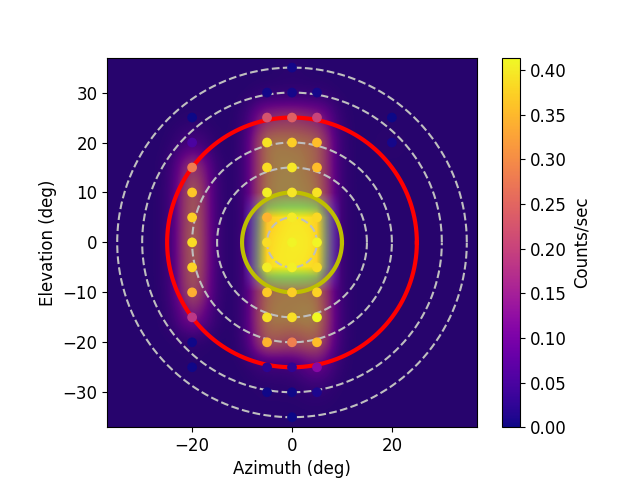

In [17]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
#figure(figsize=(5,5))
matplotlib.rc('font', **font)
plot_angular_response(az=azimuth,el=elevation,cps=countsPerSec,colorMapImage=1,highlightArea=1,centroid=1)
savefig("plotFigs/angResponseColorAreaCent.svg")

<IPython.core.display.Javascript object>


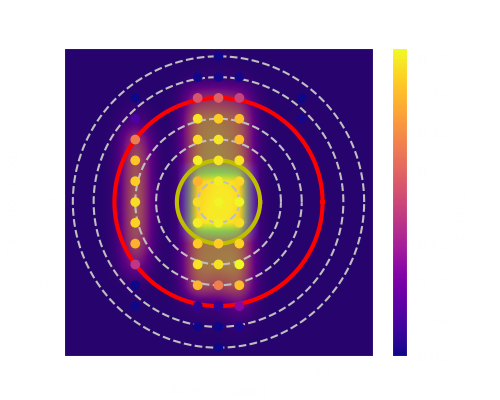

In [10]:
%matplotlib notebook
import matplotlib
with matplotlib.pyplot.style.context(("dark_background")):
    font = {'family' : 'normal',
            'weight' : 'regular',
            'size'   : 10}
    figure(figsize=(5,4))
    #subplot(111)
    matplotlib.rc('font', **font)
    plot_angular_response(az=azimuth,el=elevation,cps=countsPerSec,colorMapImage=1,highlightArea=1,centroid=1)
    savefig("plotFigs/angResponseColorAreaCentBlack.svg",transparent=True)

<IPython.core.display.Javascript object>


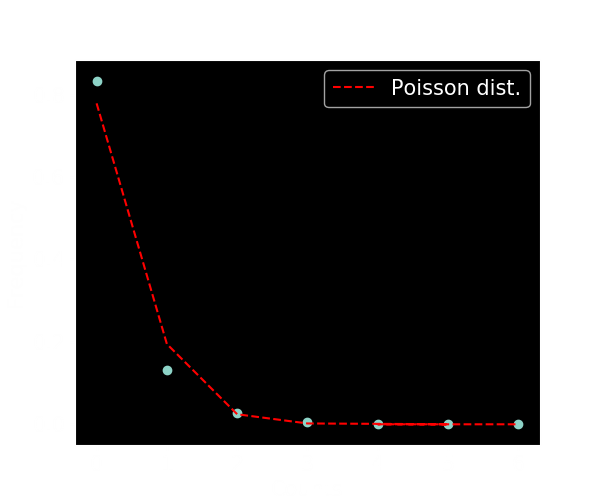

In [22]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 15}
matplotlib.rc('font', **font)
figure(figsize=(6,5))
with matplotlib.pyplot.style.context(("dark_background")):
    count_frecuency(bns, countsPerSec)
    title("")
    savefig("plotFigs/countFrequencyBlack.svg",transparent=True)

<IPython.core.display.Javascript object>


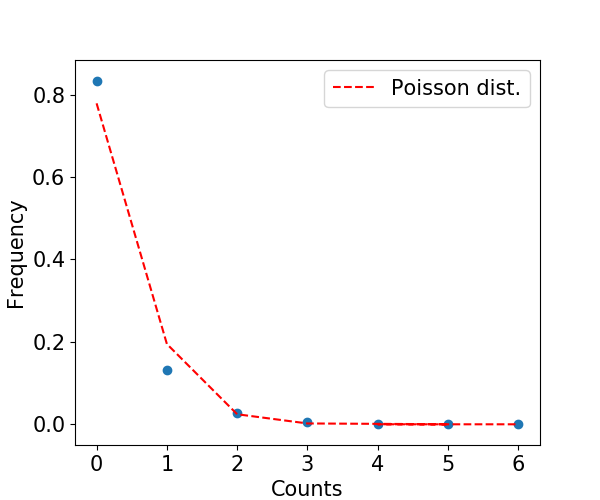

In [23]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 15}
matplotlib.rc('font', **font)
figure(figsize=(6,5))
count_frecuency(bns, countsPerSec)
title("")
savefig("plotFigs/countFrequency.svg",transparent=True)